In [1]:
from tmd import TMD
from torch_geometric.datasets import TUDataset
import random

C:\Users\ekima\anaconda3\envs\graphs\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = TUDataset('data', name='MUTAG')
d = TMD(dataset[0], dataset[1], w=1.0, L=1)
print(d)

5.414213538169861


In [3]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx,from_networkx

import matplotlib.pyplot as plt
import numpy as np
import torch
import ot
import copy
import seaborn as sns
from torch_geometric.data.data import Data

In [4]:
# def get_cost_matrix(n):

#     m = np.zeros((n,n))
#     for i in range(n):
#         for j in range(n):
#             if (i == 0) | (j == 0):
#                 m[i][j] = abs(i-j) + 1
#             else: 
#                 m[i][j] = abs(i-j)
#     return m 
# get_cost_matrix(n=4)


array([[1., 2., 3., 4.],
       [2., 0., 1., 2.],
       [3., 1., 0., 1.],
       [4., 2., 1., 0.]])

In [528]:
def get_cost_matrix(n):

    m = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            m[i][j] = abs(i-j)
    return m 
get_cost_matrix(n=4)

array([[0., 1., 2., 3.],
       [1., 0., 1., 2.],
       [2., 1., 0., 1.],
       [3., 2., 1., 0.]])

## Graph visualizations

C:\Users\ekima\anaconda3\envs\graphs\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


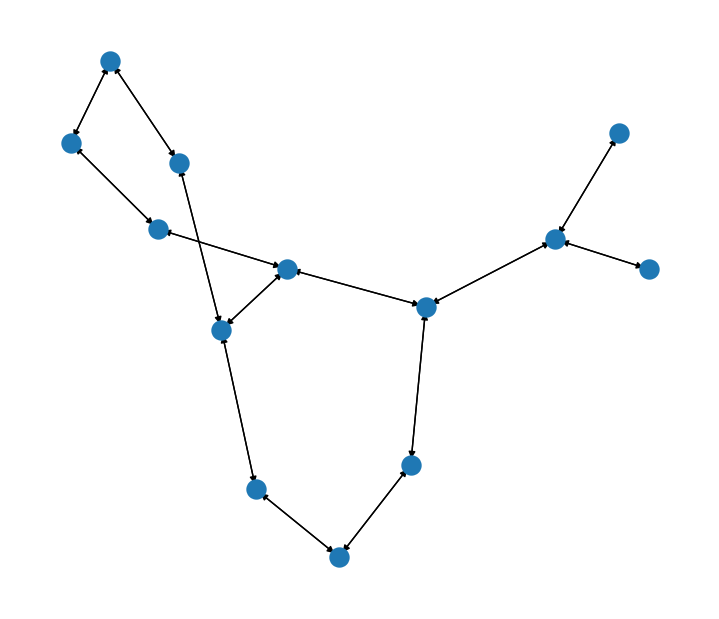

In [5]:

data = dataset[2]
coragraph = to_networkx(data)

plt.figure(1,figsize=(7,6)) 
nx.draw(coragraph, cmap=plt.get_cmap('Set1'),node_size=75,linewidths=6)
plt.show()

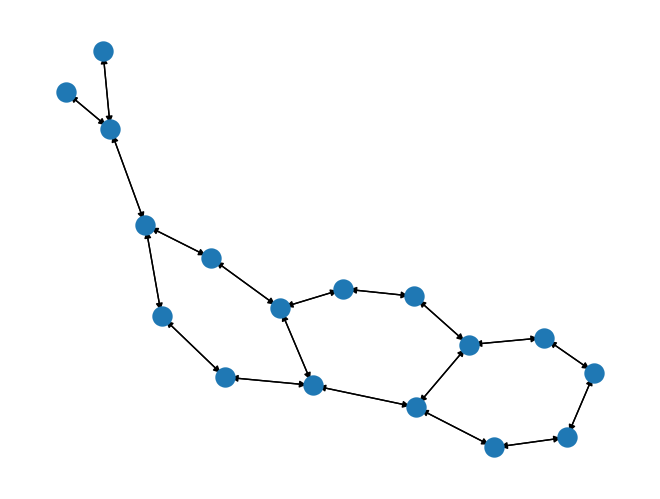

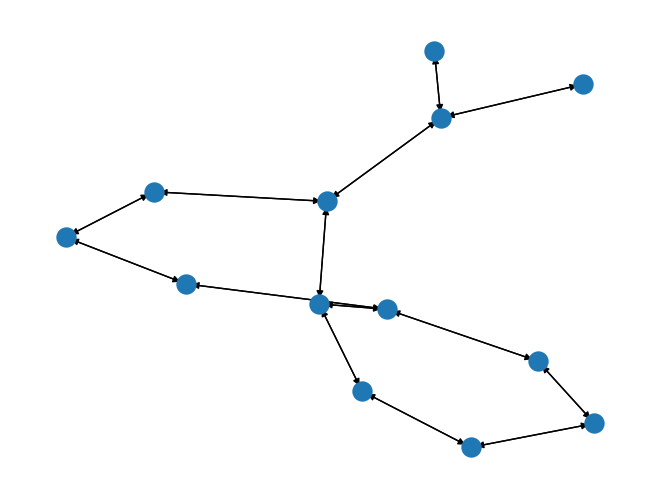

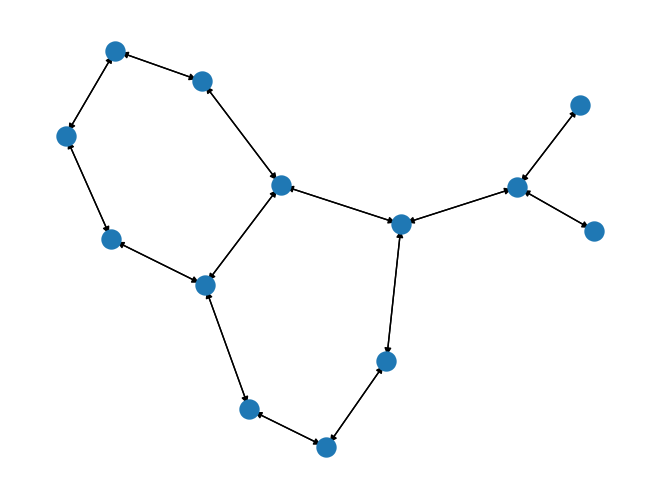

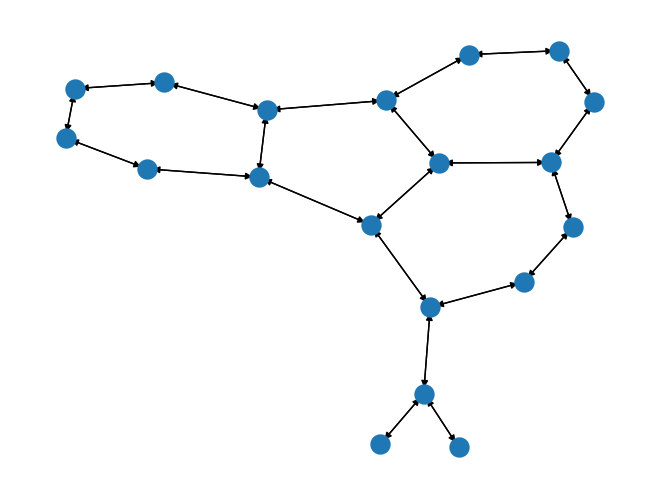

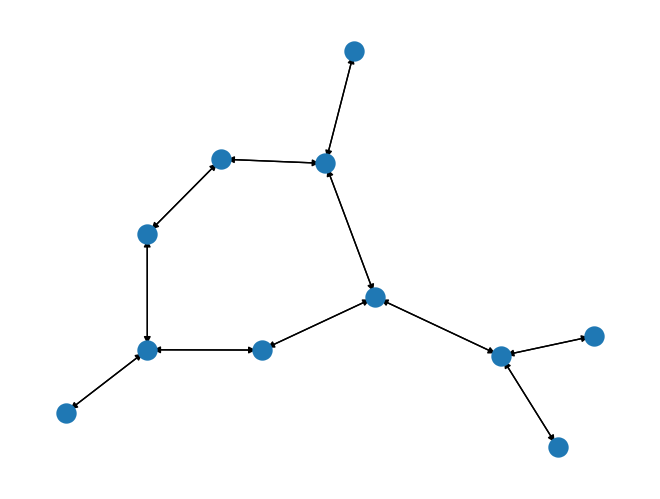

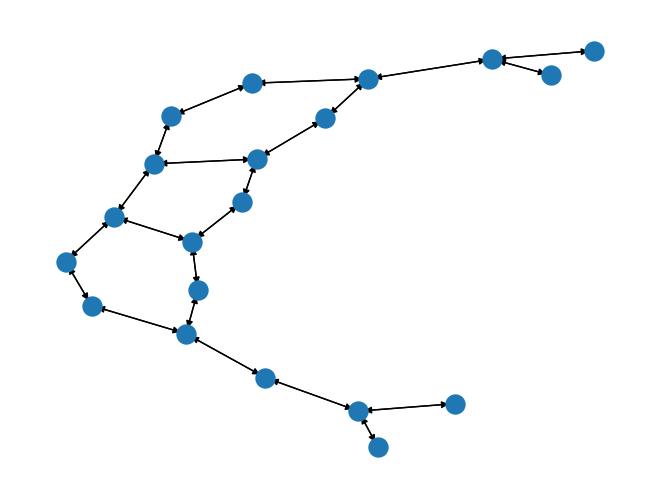

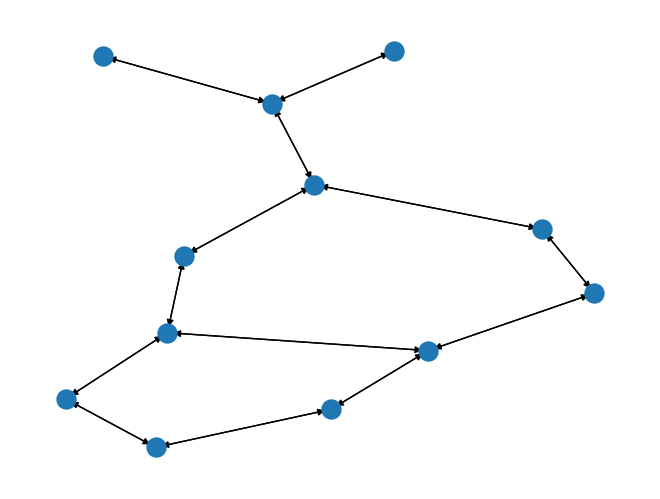

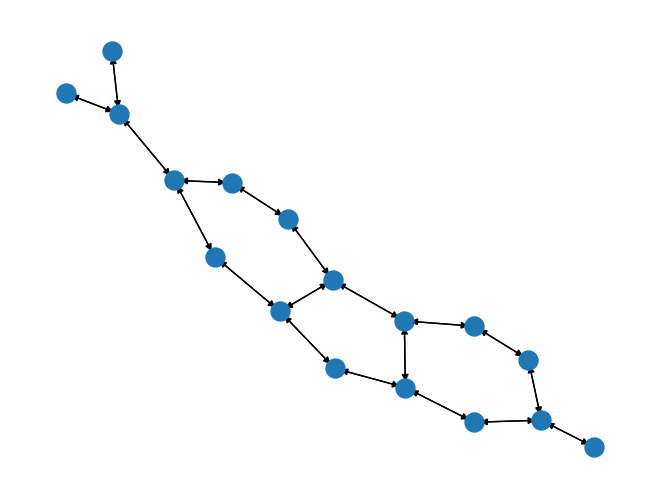

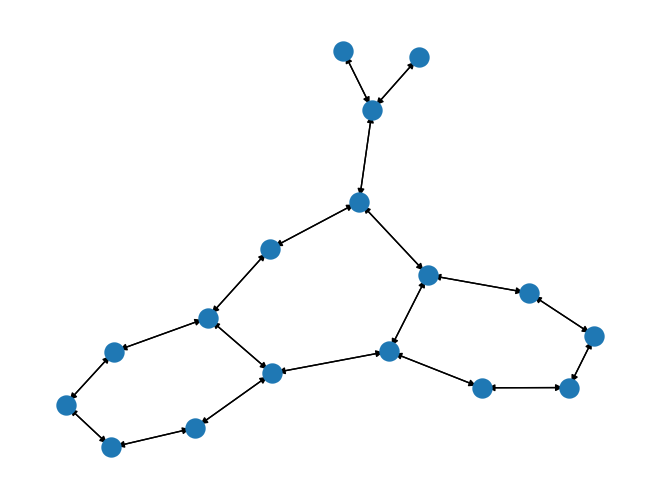

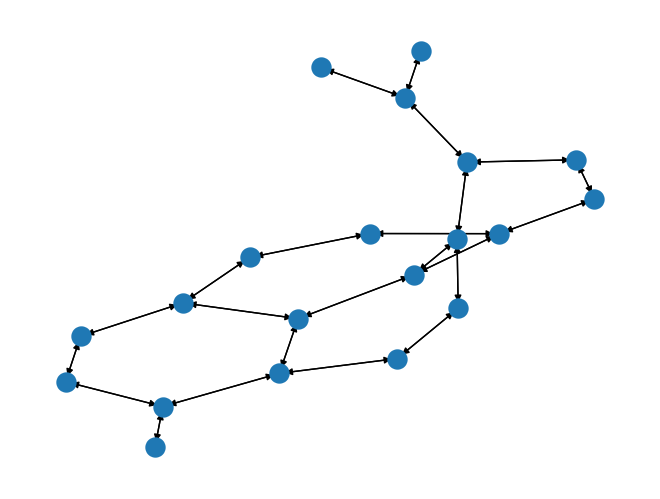

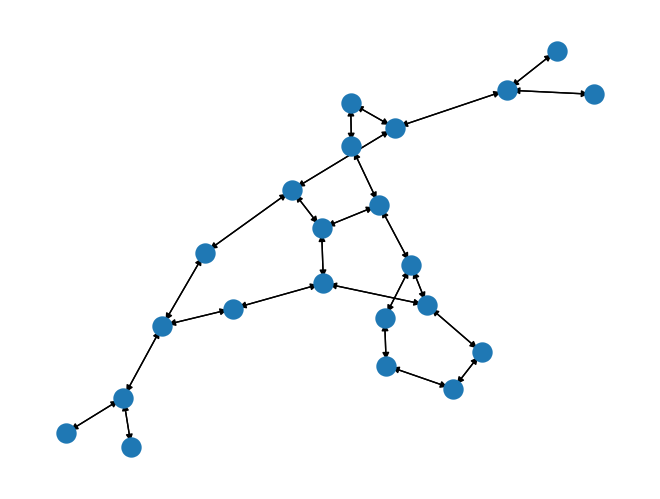

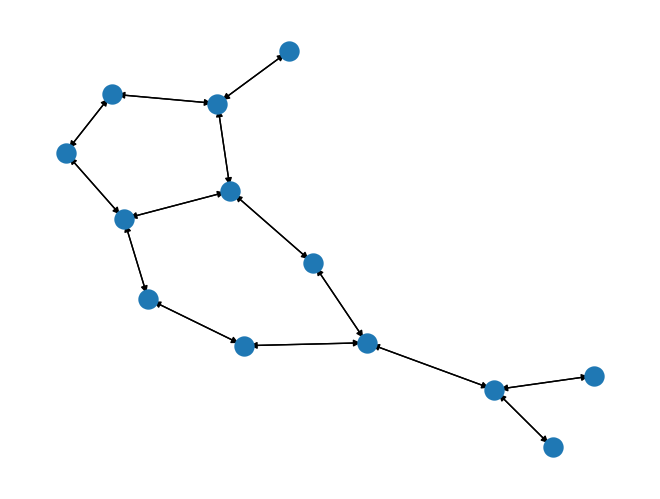

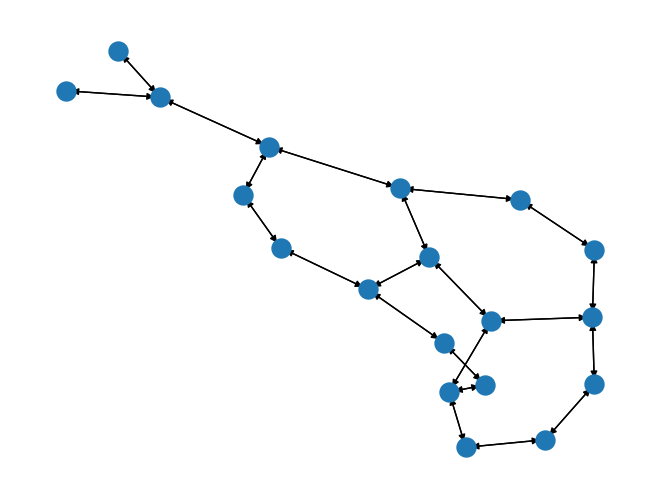

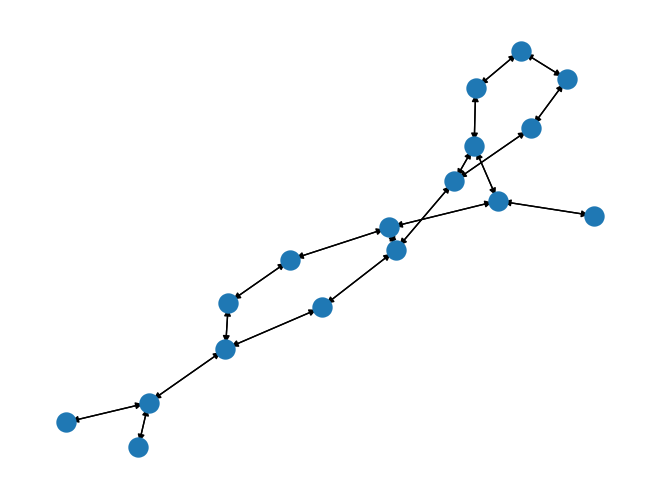

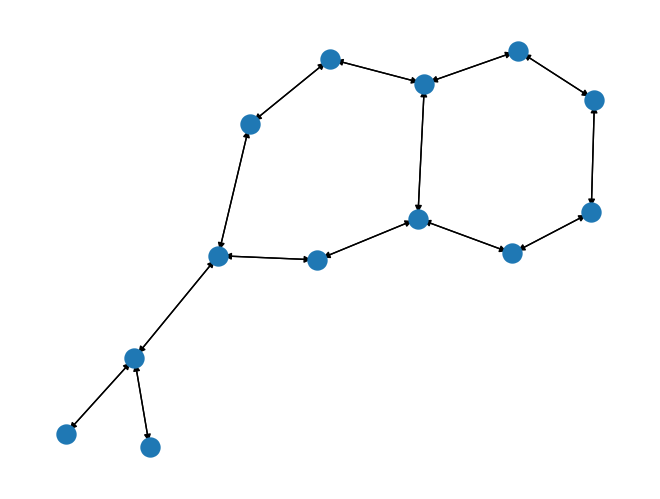

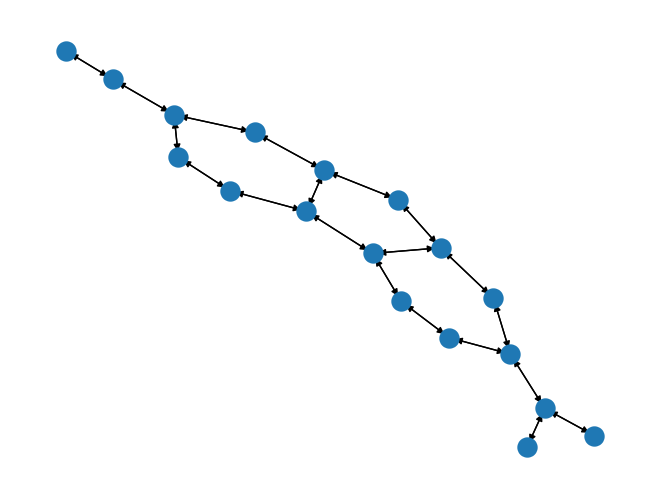

In [6]:
for i in range(20):
    data = dataset[i]
    coragraph = to_networkx(data)
    nx.draw(coragraph, cmap=plt.get_cmap('Set1'),node_size=75,linewidths=6)
    plt.show()

## Functions

In [7]:
def get_neighbors(g):
    '''
    get neighbor indexes for each node
    Parameters
    ----------
    g : input torch_geometric graph
    Returns
    ----------
    adj: a dictionary that store the neighbor indexes
    '''
    adj = {}
    for i in range(len(g.edge_index[0])):
        node1 = g.edge_index[0][i].item()
        node2 = g.edge_index[1][i].item()
        if node1 in adj.keys():
            adj[node1].append(node2)
        else:
            adj[node1] = [node2]
    return adj


In [8]:

def draw_graph(data):
    coragraph = to_networkx(data)
    nx.draw(coragraph, cmap=plt.get_cmap('Set1'),node_size=120,linewidths=6, with_labels=True, node_color='red') 
    plt.show()  

In [588]:

def TMD_original(g1, g2, w, L=4):
    '''
    return the Tree Mover’s Distance (TMD) between g1 and g2

    Parameters
    ----------
    g1, g2 : two torch_geometric graphs
    w : weighting constant for each depth
         if it is a list, then w[l] is the weight for depth-(l+1) tree
         if it is a constant, then every layer shares the same weight
    L    : Depth of computation trees for calculating TMD

    Returns
    ----------
    wass : The TMD between g1 and g2

    Reference
    ----------
    Chuang et al., Tree Mover’s Distance: Bridging Graph Metrics and
    Stability of Graph Neural Networks, NeurIPS 2022
    '''

    # if isinstance(w, list):
    #     assert(len(w) == L-1)
    # else:
    #     w = [w] * (L-1)
    w = 1
    # get attributes
    n1, n2 = len(g1.x), len(g2.x)
    feat1, feat2 = g1.x, g2.x
    adj1 = get_neighbors(g1)
    adj2 = get_neighbors(g2)
    feat1 = torch.ones(n1,1)
    feat2 = torch.ones(n2,1)
    
    blank = np.zeros(len(feat1[0]))
    D = np.zeros((n1, n2))

    # level 1 (pair wise distance)
    M = np.zeros((n1+1, n2+1))
    for i in range(n1):
        for j in range(n2):
            D[i, j] = torch.norm(feat1[i] - feat2[j])
            M[i, j] = D[i, j]
    # distance w.r.t. blank node
    M[:n1, n2] = torch.norm(feat1, dim=1)
    M[n1, :n2] = torch.norm(feat2, dim=1)

    # level l (tree OT)
    for l in range(L-1):
        M1 = copy.deepcopy(M)
        M = np.zeros((n1+1, n2+1))

        # calculate pairwise cost between tree i and tree j
        for i in range(n1):
            for j in range(n2):
                try:
                    degree_i = len(adj1[i])
                except:
                    degree_i = 0
                try:
                    degree_j = len(adj2[j])
                except:
                    degree_j = 0

                if degree_i == 0 and degree_j == 0:
                    M[i, j] = D[i, j]
                # if degree of node is zero, calculate TD w.r.t. blank node
                elif degree_i == 0:
                    # set_trace()
                    wass = 0.
                    for jj in range(degree_j):
                        wass += M1[n1, adj2[j][jj]]
                    M[i, j] = D[i, j] + w * wass
                elif degree_j == 0:
                    # set_trace()
                    wass = 0.
                    for ii in range(degree_i):
                        wass += M1[adj1[i][ii], n2]
                    M[i, j] = D[i, j] + w * wass
                # otherwise, calculate the tree distance
                else:
                    max_degree = max(degree_i, degree_j)
                    if degree_i < max_degree:
                        cost = np.zeros((degree_i + 1, degree_j))
                        cost[degree_i] = M1[n1, adj2[j]]
                        dist_1, dist_2 = np.ones(degree_i + 1), np.ones(degree_j)
                        dist_1[degree_i] = max_degree - float(degree_i)
                    else:
                        cost = np.zeros((degree_i, degree_j + 1))
                        cost[:, degree_j] = M1[adj1[i], n2]
                        dist_1, dist_2 = np.ones(degree_i), np.ones(degree_j + 1)
                        dist_2[degree_j] = max_degree - float(degree_j)
                    for ii in range(degree_i):
                        for jj in range(degree_j):
                            cost[ii, jj] =  M1[adj1[i][ii], adj2[j][jj]]
                    wass = ot.emd2(dist_1, dist_2, cost)

                    # summarize TMD at level l
                    M[i, j] = D[i, j] + w * wass

        # fill in dist w.r.t. blank node
        for i in range(n1):
            try:
                degree_i = len(adj1[i])
            except:
                degree_i = 0

            if degree_i == 0:
                M[i, n2] = torch.norm(feat1[i])
            else:
                wass = 0.
                for ii in range(degree_i):
                    wass += M1[adj1[i][ii], n2]
                M[i, n2] = torch.norm(feat1[i]) + w * wass

        for j in range(n2):
            try:
                degree_j = len(adj2[j])
            except:
                degree_j = 0
            if degree_j == 0:
                M[n1, j] = torch.norm(feat2[j])
            else:
                wass = 0.
                for jj in range(degree_j):
                    wass += M1[n1, adj2[j][jj]]
                M[n1, j] = torch.norm(feat2[j]) + w * wass


    # final OT cost
    max_n = max(n1, n2)
    dist_1, dist_2 = np.ones(n1+1), np.ones(n2+1)
    if n1 < max_n:
        dist_1[n1] = max_n - float(n1)
        dist_2[n2] = 0.
    else:
        dist_1[n1] = 0.
        dist_2[n2] = max_n - float(n2)

    wass = ot.emd2(dist_1, dist_2, M)
    return wass
    # return dist_1, dist_2, M, wass

In [10]:
def TMD(g1, g2, w, L=4):
    
    '''
    return the Tree Mover’s Distance (TMD) between g1 and g2

    Parameters
    ----------
    g1, g2 : two torch_geometric graphs
    w : weighting constant for each depth
         if it is a list, then w[l] is the weight for depth-(l+1) tree
         if it is a constant, then every layer shares the same weight
    L    : Depth of computation trees for calculating TMD

    Returns
    ----------
    wass : The TMD between g1 and g2

    Reference
    ----------
    Chuang et al., Tree Mover’s Distance: Bridging Graph Metrics and
    Stability of Graph Neural Networks, NeurIPS 2022
    '''

    if isinstance(w, list):
        assert(len(w) == L-1)
    else:
        w = [w] * (L-1)

    # get attributes
    n1, n2 = len(g1.x), len(g2.x)
    feat1, feat2 = g1.x, g2.x
    adj1 = get_neighbors(g1)
    adj2 = get_neighbors(g2)
    feat1 = torch.ones(n1,1)
    feat2 = torch.ones(n2,1)
    
    blank = np.zeros(len(feat1[0]))
    D = np.zeros((n1, n2))

    # level 1 (pair wise distance)
    M = np.zeros((n1+1, n2+1))
    for i in range(n1):
        for j in range(n2):
            D[i, j] = torch.norm(feat1[i] - feat2[j])
            M[i, j] = D[i, j]
    # distance w.r.t. blank node
    M[:n1, n2] = torch.norm(feat1, dim=1)
    M[n1, :n2] = torch.norm(feat2, dim=1)
    
    # level l (tree OT)
    for l in range(L-1):
        # if l == 1: 
        #     from pdb import set_trace; set_trace()
        M1 = copy.deepcopy(M)
        M = np.zeros((n1+1, n2+1))

        # calculate pairwise cost between tree i and tree j
        for i in range(n1):
            for j in range(n2):
                try:
                    degree_i = len(adj1[i])
                except:
                    degree_i = 0
                try:
                    degree_j = len(adj2[j])
                except:
                    degree_j = 0

                if degree_i == 0 and degree_j == 0:
                    M[i, j] = D[i, j]
                # if degree of node is zero, calculate TD w.r.t. blank node
                elif degree_i == 0:
                    wass = 0.
                    for jj in range(degree_j):
                        wass += M1[n1, adj2[j][jj]]
                    M[i, j] = D[i, j] + w * wass
                elif degree_j == 0:
                    wass = 0.
                    for ii in range(degree_i):
                        wass += M1[adj1[i][ii], n2]
                    M[i, j] = D[i, j] + w * wass
                # otherwise, calculate the tree distance
                else:
                    max_degree = max(degree_i, degree_j)
                    if degree_i < max_degree:
                        cost = np.zeros((degree_i + 1, degree_j))
                        cost[degree_i] = M1[n1, adj2[j]]
                        dist_1, dist_2 = np.ones(degree_i + 1), np.ones(degree_j)
                        dist_1[degree_i] = max_degree - float(degree_i)
                    else:
                        cost = np.zeros((degree_i, degree_j + 1))
                        cost[:, degree_j] = M1[adj1[i], n2]
                        dist_1, dist_2 = np.ones(degree_i), np.ones(degree_j + 1)
                        dist_2[degree_j] = max_degree - float(degree_j)
                    for ii in range(degree_i):
                        for jj in range(degree_j):
                            cost[ii, jj] =  M1[adj1[i][ii], adj2[j][jj]]

                    wass = ot.emd2(dist_1, dist_2, cost)
                    # if l == 1: 
                    # print(l, i, j, degree_i, degree_j, "dist 1: ", dist_1,  "dist 2: ", dist_2, "cost", cost, wass)
                    # summarize TMD at level l
                    M[i, j] = D[i, j] + w[l] * wass

        # fill in dist w.r.t. blank node
        for i in range(n1):
            try:
                degree_i = len(adj1[i])
            except:
                degree_i = 0

            if degree_i == 0:
                M[i, n2] = torch.norm(feat1[i])
            else:
                wass = 0.
                for ii in range(degree_i):
                    wass += M1[adj1[i][ii], n2]
                M[i, n2] = torch.norm(feat1[i]) + w[l] * wass

        for j in range(n2):
            try:
                degree_j = len(adj2[j])
            except:
                degree_j = 0
            if degree_j == 0:
                M[n1, j] = torch.norm(feat2[j])
            else:
                wass = 0.
                for jj in range(degree_j):
                    wass += M1[n1, adj2[j][jj]]
                M[n1, j] = torch.norm(feat2[j]) + w[l] * wass


    # final OT cost
    max_n = max(n1, n2)
    dist_1, dist_2 = np.ones(n1+1), np.ones(n2+1)
    if n1 < max_n:
        dist_1[n1] = max_n - float(n1)
        dist_2[n2] = 0.
    else:
        dist_1[n1] = 0.
        dist_2[n2] = max_n - float(n2)

    wass = ot.emd2(dist_1, dist_2, M)
    return dist_1, dist_2, M, wass

In [11]:
def get_distrib(d1):
    adj = get_neighbors(d1)
    lens1 = []
    
    for v in adj.values():
        lens1.append(len(v))  
    return lens1

In [12]:
def calc_distrib(d1, d2):
    adj = get_neighbors(d1)
    lens1 = []
    for v in adj.values():
        lens1.append(len(v))  
    adj = get_neighbors(d2)
    lens2 = []
    for v in adj.values():
        lens2.append(len(v))

    max_max = max(max(lens1), max(lens2)) + 1


    a1 = []
    a2 = []
    for v in range(max_max):
        a1.append(lens1.count(v))
        a2.append(lens2.count(v))
  
    return a1, a2, max_max

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def plot_distr_plot(d1):
    fig = plt.figure("Degree of a graph", figsize=(6, 4))
    ax2 = fig.add_subplot()
    ax2.bar(*np.unique(get_distrib(d1), return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")
    fig.tight_layout()
    plt.show()

In [14]:
def plot_graph(G):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)

    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title("Connected components of G")
    ax0.set_axis_off()

    fig.tight_layout()
    plt.show()

In [36]:
def calc_barycenter(a1, a2, n, alpha=0.2, reg=1e-3):
    ## basrycenters 
    # creating matrix A containing all distributions

    # # bin positions
    x = np.arange(n, dtype=np.float64)

    # # Gaussian distributions
    # a1 = ot.datasets.make_1D_gauss(n, m=20, s=5)  # m= mean, s= std
    # a2 = ot.datasets.make_1D_gauss(n, m=60, s=8)

    # creating matrix A containing all distributions
    A = np.vstack((a1, a2)).T
    n_distributions = A.shape[1]

    # loss matrix + normalization
    M = ot.utils.dist0(n)
    M /= M.max()

    # alpha = 0.2  # 0<=alpha<=1
    weights = np.array([1 - alpha, alpha])

    # l2bary
    bary_l2 = A.dot(weights)

    # wasserstein
    # reg = 1e-3
    bary_wass = ot.bregman.barycenter(A, M, reg, weights)

    f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, num=1)
    ax1.plot(x, A, color="black")
    ax1.set_title('Distributions')

    ax2.plot(x, bary_l2, 'r', label='l2')
    ax2.plot(x, bary_wass, 'g', label='Wasserstein')
    ax2.set_title('Barycenters')

    plt.legend()
    plt.show()
    return bary_l2, bary_wass

## Graphs for the same histograms  

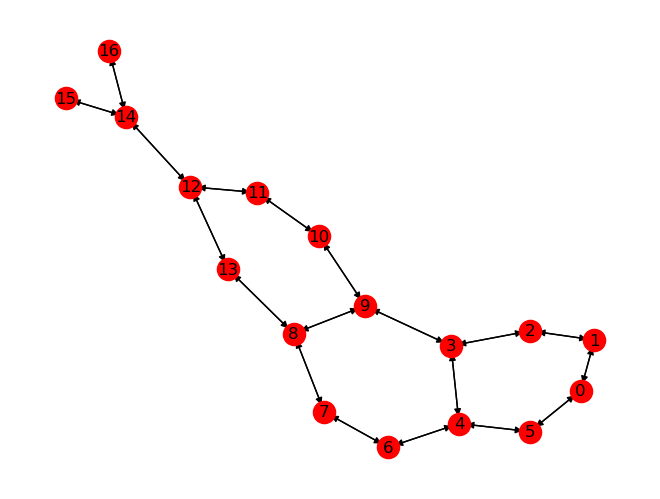

In [33]:
draw_graph(dataset[0])

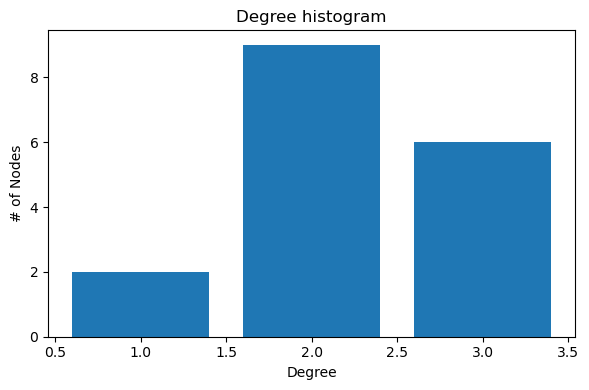

Degree sequence:  [2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 1, 1]
Degree histogram:  [0, 2, 9, 6]


In [34]:
d1 = dataset[0]
degrees = get_distrib(d1)
max_degree = max(degrees) + 1
h = []
for v in range(max_degree):
    h.append(degrees.count(v))
plot_distr_plot(d1)
print("Degree sequence: ", degrees)
print("Degree histogram: ", h)

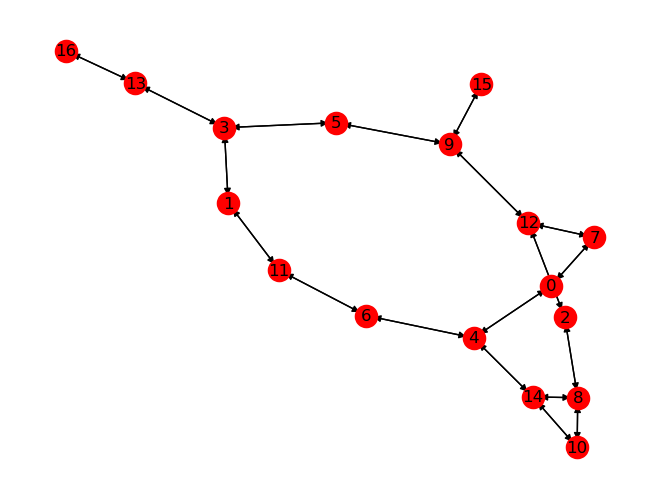

Dist dataset 0 - generated, level = 2 :  0.0
Dist dataset 0 - generated, level = 3 :  8.0
Dist dataset 0 - generated, level = 4 :  32.0


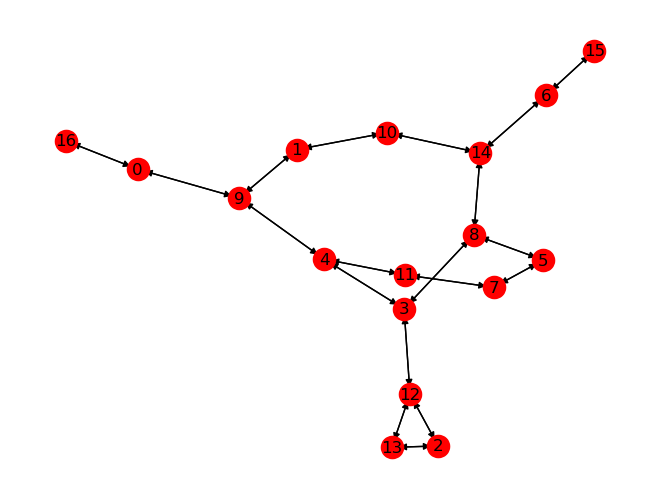

Dist dataset 0 - generated, level = 2 :  0.0
Dist dataset 0 - generated, level = 3 :  10.0
Dist dataset 0 - generated, level = 4 :  38.0


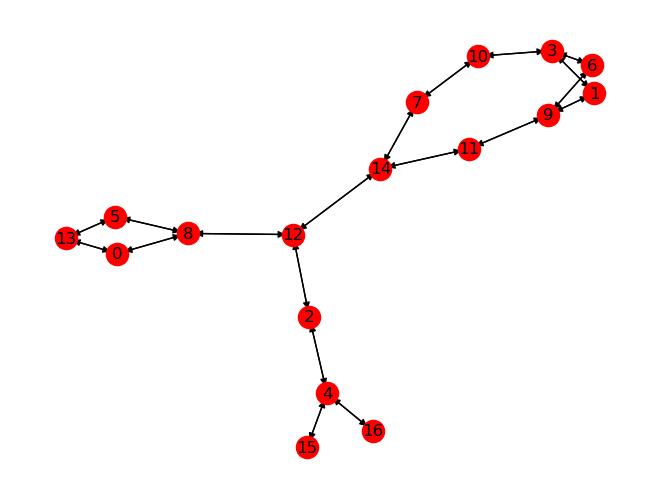

Dist dataset 0 - generated, level = 2 :  0.0
Dist dataset 0 - generated, level = 3 :  8.0
Dist dataset 0 - generated, level = 4 :  40.0


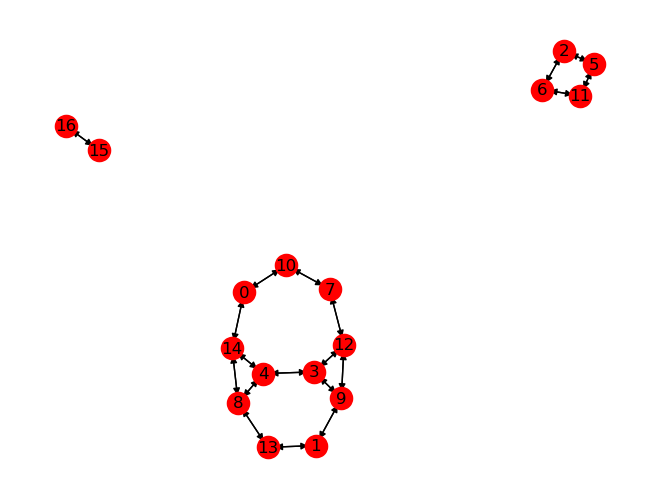

Dist dataset 0 - generated, level = 2 :  0.0
Dist dataset 0 - generated, level = 3 :  16.0
Dist dataset 0 - generated, level = 4 :  72.0


Dist dataset 0 - generated, level = 2 :  0.0
Dist dataset 0 - generated, level = 3 :  10.0
Dist dataset 0 - generated, level = 4 :  44.0


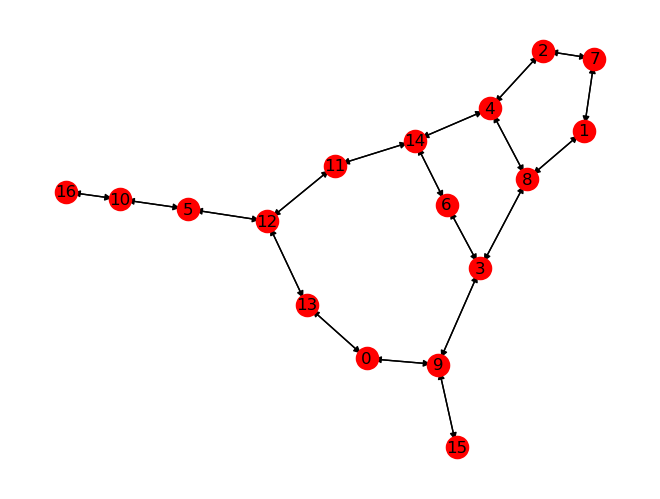

Dist dataset 0 - generated, level = 2 :  0.0
Dist dataset 0 - generated, level = 3 :  6.0
Dist dataset 0 - generated, level = 4 :  30.0


Dist dataset 0 - generated, level = 2 :  0.0
Dist dataset 0 - generated, level = 3 :  6.0
Dist dataset 0 - generated, level = 4 :  28.0


Dist dataset 0 - generated, level = 2 :  0.0
Dist dataset 0 - generated, level = 3 :  8.0
Dist dataset 0 - generated, level = 4 :  38.0


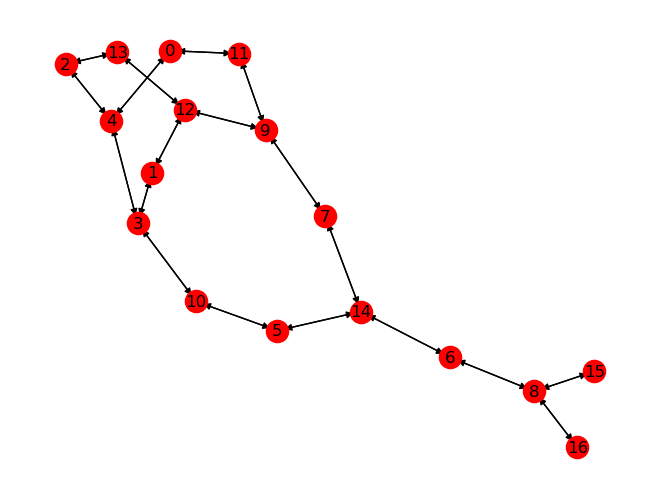

Dist dataset 0 - generated, level = 2 :  0.0
Dist dataset 0 - generated, level = 3 :  8.0
Dist dataset 0 - generated, level = 4 :  34.0


Dist dataset 0 - generated, level = 2 :  0.0
Dist dataset 0 - generated, level = 3 :  4.0
Dist dataset 0 - generated, level = 4 :  18.0


In [35]:
for i in range(10):
    draw = degrees
    is_good = False
    while(not is_good):
        z = list(draw)
        G = nx.configuration_model(z)
        G = nx.Graph(G)
        G.remove_edges_from(nx.selfloop_edges(G))

        actual_degrees = [d for v, d in G.degree()]
        is_good = actual_degrees == z
    # plot_graph(G)
    new_G = from_networkx(G)
    new_G.x = torch.ones(new_G.num_nodes, 1)
    draw_graph(new_G)
    wass_2 = TMD_original(d1, new_G, 1, L=2)
    wass_3 = TMD_original(d1, new_G, 1, L=3)
    wass_4 = TMD_original(d1, new_G, 1, L=4)

    print("Dist dataset 0 - generated, level = 2 : ", wass_2)
    print("Dist dataset 0 - generated, level = 3 : ", wass_3)
    print("Dist dataset 0 - generated, level = 4 : ", wass_4)

## Following the path, functions

Change 1


C:\Users\ekima\AppData\Local\Temp\ipykernel_26288\4235675897.py:30: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  path, d = ot.emd(a1, a2, cost_matrix, log=True)


In [715]:
def update_path(path):
    for i in range(path.shape[0]):
        for j in range(path.shape[1]):
            if (j - i == 2) & (path[i][j] > 0):
                value = path[i][j]
                path[i][j] = 0
                path[i][j-1] += value 
                path[i+1][j] += value
                print(i, j)
            if (j - i == 3) & (path[i][j] > 0):
                value = path[i][j]
                path[i][j] = 0
                path[i][j-2] += value 
                path[i+1][j-1] += value 
                path[i+2][j] += value

                print(i, j)
    return path


In [734]:
def update_path(path):
    for i in range(path.shape[0]):
        for j in range(path.shape[1]):
            diff = j - i
            if (diff >= 2) & (path[i][j] > 0):
                value = path[i][j]
                path[i][j] = 0
                j_ind = diff - 1
                i_ind = diff - 1 - j_ind

                for k in range(diff):
                    print(diff)
                    print(i+i_ind, j-j_ind)
                    path[i+i_ind][j-j_ind] += value 
                    j_ind -= 1
                    i_ind += 1
                    
            if (diff <= -2) & (path[i][j] > 0):
                value = path[i][j]
                path[i][j] = 0
                j_ind = diff - 1
                i_ind = diff - 1 - j_ind

                for k in range(diff):
                    print(diff)
                    print(i-i_ind, j+j_ind)
                    path[i-i_ind][j+j_ind] += value 
                    j_ind -= 1
                    i_ind += 1                   
                    
                    
                    
                    
                    # diff = 2
                    # j_ind = diff - 1
                    # i_ind = diff - 1 - diff
                    
#                 path[i][j-j_ind] += value 
#                 path[i+1][j] += value
#                 print(i, j)
            # if (j - i == 3) & (path[i][j] > 0):
            #     value = path[i][j]
            #     path[i][j] = 0
            #     path[i][j-2] += value 
            #     path[i+1][j-1] += value 
            #     path[i+2][j] += value

                print(i, j)
    return path


In [726]:
path_orig1 =  path_orig.copy()

In [739]:
path

array([[0, 0, 0, 0],
       [4, 0, 0, 0],
       [0, 0, 8, 0],
       [1, 2, 1, 6]])

In [740]:
path_orig1 = update_path(path)
path_orig1

array([[0, 0, 0, 0],
       [4, 0, 0, 0],
       [0, 0, 8, 0],
       [1, 2, 1, 6]])

In [ ]:

    prob_list = [path[0][1], path[1][2], path[2][3] ]
    len_list = [len(node) for node in nodes]

In [678]:
def select_action(prob_list, len_list, actions = [0, 1, 2]):
    print(prob_list, len_list)
    weights = [prob_list[i] * len_list[i] for i in range(len(prob_list))]
    print("weights: ", weights)
    action = random.choices(actions, weights=weights, k=1)
    # print(action)
    return action[0]

In [666]:
def select_nodes(path, nodes, actions = [0, 1, 2]):

    prob_list = [path[0][1], path[1][2], path[2][3] ]
    len_list = [len(node) for node in nodes]
    print(prob_list, len_list)
    action_1 = select_action(prob_list, len_list, actions = actions)
    
    prob_list[action_1] -= 1
    len_list[action_1] -= 1
    
    action_2 = select_action(prob_list, len_list, actions = actions)
    
    
    # action_1, action_2 = random.choices(actions, weights=weights, k=2)
    print('actions: ', action_1, action_2)
    is_same_node = True
    while is_same_node: 
        node_1 = random.choice(nodes[action_1])
        node_2 = random.choice(nodes[action_2])
        is_same_node = node_1 == node_2
    return action_1, action_2, node_1, node_2

In [556]:
def get_nodes(g):
    dict_degrees = dict(g.degree)
    nodes = []
    for i in range(max(dict_degrees.values())+1):
        node_i = list(filter(lambda x: dict_degrees[x] == i, dict_degrees))
        nodes.append(node_i)
    return nodes

In [757]:
def run_step(g1, path):
    # get nodes
    nodes = get_nodes(g1)
    print("all nodes: ", nodes)
    # select actions and nodes 
    action_1, action_2, node_1, node_2 = select_nodes(path, nodes, actions = [0, 1, 2])
    print("Nodes: ", node_1, node_2)
    # add edge
    if g1.get_edge_data(node_1, node_2, default=True): # edge doesnot exist 
        g1.add_edge(node_1, node_2)
        # update path
        path[action_1][action_1+1] -= 1
        path[action_2][action_2+1] -= 1
    path_sum = path[0][1] + path[1][2] + path[2][3]
    print("Path sum: ", path_sum)
    return g1, path, path_sum

In [758]:
def run_check(g, d1, d2):
    
    data = from_networkx(g)
    data.x = torch.ones(len(list(g.nodes)), 1)
    draw_graph(data)
    
    print("Distance between original graphs: ", TMD_original(d1, d2, L=2, w=1))
    print("Distance to the first graph: ", TMD_original(d1, data, L=2, w=1))
    print("Distance to the second graph: ", TMD_original(d2, data, L=2, w=1))
    
    print('*' * 10)
    print("Distance between original graphs, level = 3: ", TMD_original(d1, d2, L=3, w=1))
    print("Distance to the first graph, level = 3: ", TMD_original(d1, data, L=3, w=1))
    print("Distance to the second graph, level = 3: ", TMD_original(d2, data, L=3, w=1))
    
    
    print('*' * 10)
    print("Distance between original graphs, level = 4: ", TMD_original(d1, d2, L=4, w=1))
    print("Distance to the first graph, level = 4: ", TMD_original(d1, data, L=4, w=1))
    print("Distance to the second graph, level = 4: ", TMD_original(d2, data, L=4, w=1))

In [759]:
# data = from_networkx(g1)
# data.x = torch.ones(len(list(g1.nodes)), 1)
# dist_1, dist_2, M, wass = TMD_original(data, d1_filled, L=2, w=1)
# sns.heatmap(M, annot=True)

In [760]:
# path, d = ot.emd(dist_1, dist_2, M, log=True) 
# sns.heatmap(M*path, annot=True)

In [761]:
# draw_graph(d1_filled)
    

In [762]:
# draw_graph(data)
#     

## Following the path, example 2

In [806]:
# set datasets
d2 = dataset[0]
d1 = dataset[1]

# calculate histograms
a1, a2, max_max = calc_distrib(d1, d2)
# aff empty nodes if needed
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
    coragraph = to_networkx(d1)
    while diff > 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff - 1
    d1_filled = from_networkx(coragraph)
    d1_filled.x = torch.ones(len(list(coragraph.nodes)), 1)
    print('Change 1')
elif diff < 0: 
    a2[0] = abs(diff)
    coragraph = to_networkx(d2)
    while diff < 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff + 1
    d2_filled = from_networkx(coragraph)
    d2_filled.x = torch.ones(len(list(coragraph.nodes)), 1)
    print('Change 2')
cost_matrix = get_cost_matrix(max_max)

# dist_1, dist_2, M, wass = TMD(d1, d2, 1, L=l)
path, d = ot.emd(a1, a2, cost_matrix, log=True) 

Change 1


C:\Users\ekima\AppData\Local\Temp\ipykernel_26288\4235675897.py:30: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  path, d = ot.emd(a1, a2, cost_matrix, log=True)


In [807]:
a1,a2

([4, 2, 7, 4], [0, 2, 9, 6])

In [808]:
g1 = to_networkx(d1_filled)
g1 = g1.to_undirected()
path_orig = path
# path = update_path(path_orig)

In [809]:
path

array([[0, 2, 0, 2],
       [0, 0, 2, 0],
       [0, 0, 7, 0],
       [0, 0, 0, 4]])

In [810]:

path = update_path(path_orig)
path

3
0 1
3
1 2
3
2 3
0 3


array([[0, 4, 0, 0],
       [0, 0, 4, 0],
       [0, 0, 7, 2],
       [0, 0, 0, 4]])

all nodes:  [[13, 14, 15, 16], [11, 12], [0, 1, 3, 4, 5, 6, 9], [2, 7, 8, 10]]
[4, 4, 2] [4, 2, 7, 4]
[4, 4, 2] [4, 2, 7, 4]
weights:  [16, 8, 14]
[4, 4, 1] [4, 2, 6, 4]
weights:  [16, 8, 6]
actions:  2 2
Nodes:  6 4
Path sum:  8


Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  12.0
Distance to the second graph, level = 3:  30.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  48.0
Distance to the second graph, level = 4:  88.0
all nodes:  [[13, 14, 15, 16], [11, 12], [0, 1, 3, 5, 9], [2, 4, 6, 7, 8, 10]]
[4, 4, 0] [4, 2, 5, 6]
[4, 4, 0] [4, 2, 5, 6]
weights:  [16, 8, 0]
[3, 4, 0] [3, 2, 5, 6]
weights:  [9, 8, 0]
actions:  0 0
Nodes:  14 15
Path sum:  6


Distance between original graphs:  10.0
Distance to the first graph:  4.0
Distance to the second graph:  6.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  16.0
Distance to the second graph, level = 3:  26.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  54.0
Distance to the second graph, level = 4:  82.0
all nodes:  [[13, 16], [11, 12, 14, 15], [0, 1, 3, 5, 9], [2, 4, 6, 7, 8, 10]]
[2, 4, 0] [2, 4, 5, 6]
[2, 4, 0] [2, 4, 5, 6]
weights:  [4, 16, 0]
[2, 3, 0] [2, 3, 5, 6]
weights:  [4, 9, 0]
actions:  1 1
Nodes:  11 15
Path sum:  4


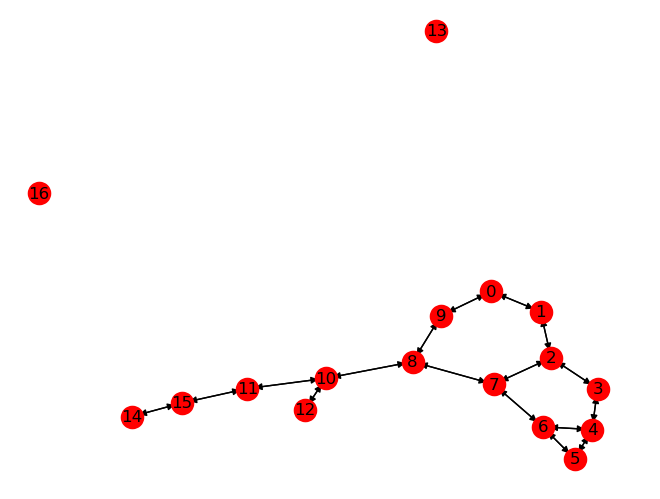

Distance between original graphs:  10.0
Distance to the first graph:  6.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  24.0
Distance to the second graph, level = 3:  20.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  78.0
Distance to the second graph, level = 4:  66.0
all nodes:  [[13, 16], [12, 14], [0, 1, 3, 5, 9, 11, 15], [2, 4, 6, 7, 8, 10]]
[2, 2, 0] [2, 2, 7, 6]
[2, 2, 0] [2, 2, 7, 6]
weights:  [4, 4, 0]
[1, 2, 0] [1, 2, 7, 6]
weights:  [1, 4, 0]
actions:  0 1
Nodes:  13 12
Path sum:  2


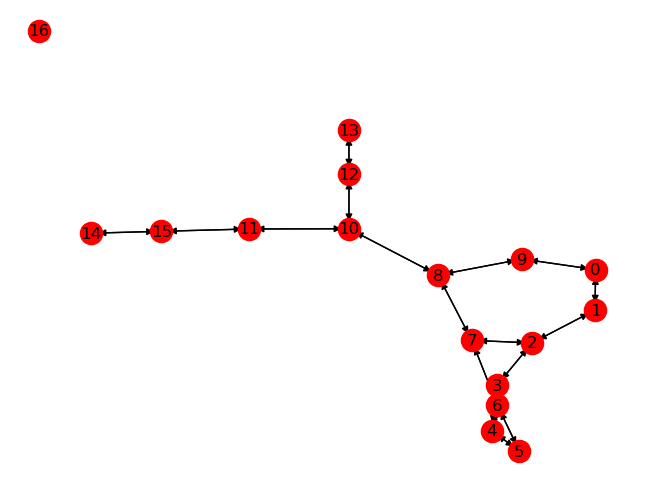

Distance between original graphs:  10.0
Distance to the first graph:  8.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  30.0
Distance to the second graph, level = 3:  16.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  94.0
Distance to the second graph, level = 4:  56.0
all nodes:  [[16], [13, 14], [0, 1, 3, 5, 9, 11, 12, 15], [2, 4, 6, 7, 8, 10]]
[1, 1, 0] [1, 2, 8, 6]
[1, 1, 0] [1, 2, 8, 6]
weights:  [1, 2, 0]
[1, 0, 0] [1, 1, 8, 6]
weights:  [1, 0, 0]
actions:  1 0
Nodes:  13 16
Path sum:  0


Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  0.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  36.0
Distance to the second graph, level = 3:  10.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  108.0
Distance to the second graph, level = 4:  44.0


In [766]:
path_sum = 1
while path_sum > 0:
    g1, path, path_sum = run_step(g1, path)
    run_check(g1, d1_filled, d2)

## Following the path, example 3

In [767]:
# draw_graph(dataset[3])

In [768]:
# draw_graph(dataset[2])

In [769]:
# set datasets

d1 = dataset[2]
d2 = dataset[3]

# calculate histograms
a1, a2, max_max = calc_distrib(d1, d2)
# aff empty nodes if needed
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
    coragraph = to_networkx(d1)
    while diff > 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff - 1
    d1_filled = from_networkx(coragraph)
    d1_filled.x = torch.ones(len(list(coragraph.nodes)), 1)
    print('Change 1')
elif diff < 0: 
    a2[0] = abs(diff)
    coragraph = to_networkx(d2)
    while diff < 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff + 1
    d2_filled = from_networkx(coragraph)
    d2_filled.x = torch.ones(len(list(coragraph.nodes)), 1)
    print('Change 2')
cost_matrix = get_cost_matrix(max_max)

# dist_1, dist_2, M, wass = TMD(d1, d2, 1, L=l)
path, d = ot.emd(a1, a2, cost_matrix, log=True) 

Change 1


C:\Users\ekima\AppData\Local\Temp\ipykernel_26288\2592892565.py:31: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  path, d = ot.emd(a1, a2, cost_matrix, log=True)


In [770]:
g1 = to_networkx(d1_filled)
g1 = g1.to_undirected()
path_orig = path
# path = update_path(path_orig)

In [771]:
path_orig

array([[0, 2, 0, 4],
       [0, 0, 2, 0],
       [0, 0, 7, 0],
       [0, 0, 0, 4]])

In [772]:

path = update_path(path_orig)
path

3
0 1
3
1 2
3
2 3
0 3


array([[0, 6, 0, 0],
       [0, 0, 6, 0],
       [0, 0, 7, 4],
       [0, 0, 0, 4]])

all nodes:  [[13, 14, 15, 16, 17, 18], [11, 12], [0, 1, 4, 5, 6, 7, 9], [2, 3, 8, 10]]
[6, 6, 4] [6, 2, 7, 4]
[6, 6, 4] [6, 2, 7, 4]
weights:  [36, 12, 28]
[6, 6, 3] [6, 2, 6, 4]
weights:  [36, 12, 18]
actions:  2 1
Nodes:  0 12
Path sum:  14


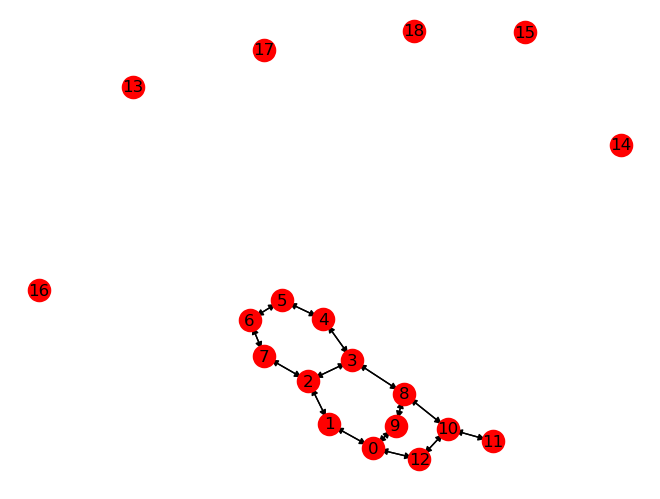

Distance between original graphs:  16.0
Distance to the first graph:  2.0
Distance to the second graph:  14.0
**********
Distance between original graphs, level = 3:  60.0
Distance to the first graph, level = 3:  10.0
Distance to the second graph, level = 3:  52.0
**********
Distance between original graphs, level = 4:  182.0
Distance to the first graph, level = 4:  36.0
Distance to the second graph, level = 4:  154.0
all nodes:  [[13, 14, 15, 16, 17, 18], [11], [1, 4, 5, 6, 7, 9, 12], [0, 2, 3, 8, 10]]
[6, 5, 3] [6, 1, 7, 5]
[6, 5, 3] [6, 1, 7, 5]
weights:  [36, 5, 21]
[6, 5, 2] [6, 1, 6, 5]
weights:  [36, 5, 12]
actions:  2 0
Nodes:  4 17
Path sum:  12


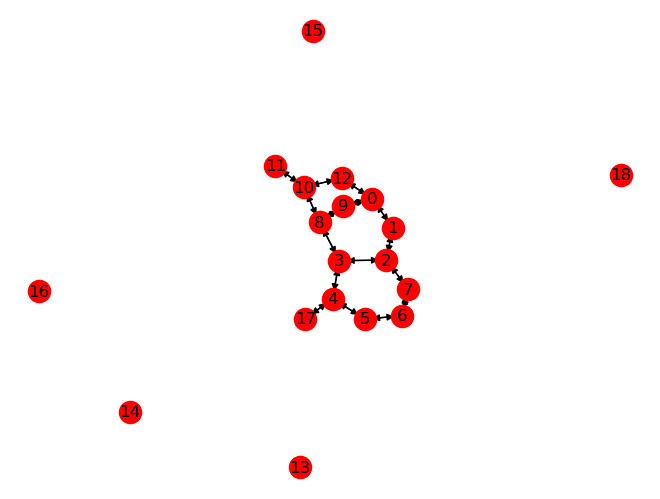

Distance between original graphs:  16.0
Distance to the first graph:  4.0
Distance to the second graph:  12.0
**********
Distance between original graphs, level = 3:  60.0
Distance to the first graph, level = 3:  18.0
Distance to the second graph, level = 3:  46.0
**********
Distance between original graphs, level = 4:  182.0
Distance to the first graph, level = 4:  60.0
Distance to the second graph, level = 4:  136.0
all nodes:  [[13, 14, 15, 16, 18], [11, 17], [1, 5, 6, 7, 9, 12], [0, 2, 3, 4, 8, 10]]
[5, 5, 2] [5, 2, 6, 6]
[5, 5, 2] [5, 2, 6, 6]
weights:  [25, 10, 12]
[5, 4, 2] [5, 1, 6, 6]
weights:  [25, 4, 12]
actions:  1 0
Nodes:  11 14
Path sum:  10


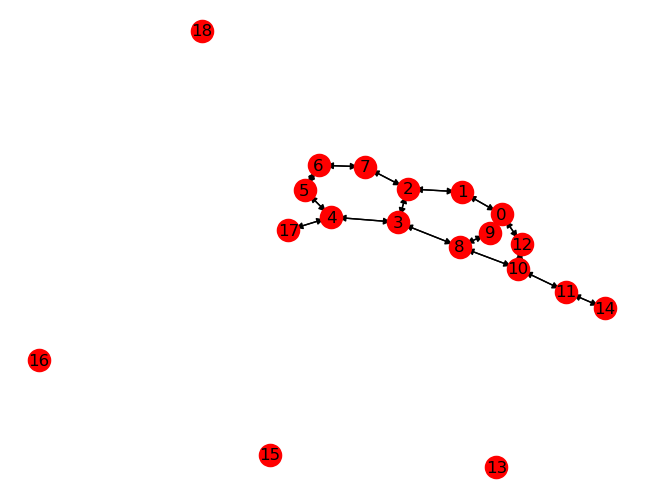

Distance between original graphs:  16.0
Distance to the first graph:  6.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  60.0
Distance to the first graph, level = 3:  24.0
Distance to the second graph, level = 3:  40.0
**********
Distance between original graphs, level = 4:  182.0
Distance to the first graph, level = 4:  76.0
Distance to the second graph, level = 4:  122.0
all nodes:  [[13, 15, 16, 18], [14, 17], [1, 5, 6, 7, 9, 11, 12], [0, 2, 3, 4, 8, 10]]
[4, 4, 2] [4, 2, 7, 6]
[4, 4, 2] [4, 2, 7, 6]
weights:  [16, 8, 14]
[4, 4, 1] [4, 2, 6, 6]
weights:  [16, 8, 6]
actions:  2 0
Nodes:  5 13
Path sum:  8


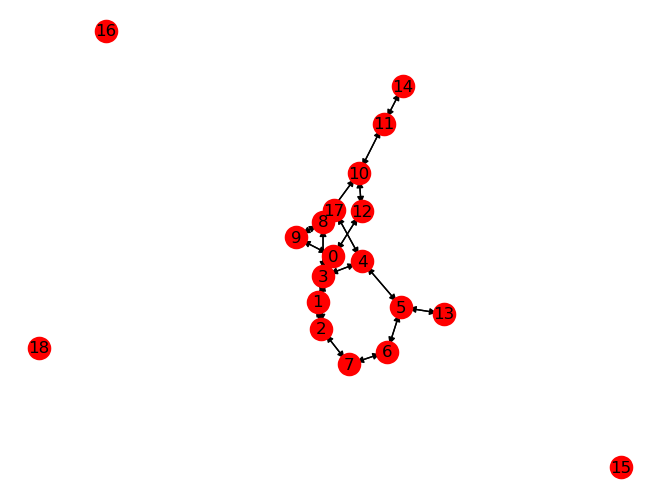

Distance between original graphs:  16.0
Distance to the first graph:  8.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  60.0
Distance to the first graph, level = 3:  32.0
Distance to the second graph, level = 3:  34.0
**********
Distance between original graphs, level = 4:  182.0
Distance to the first graph, level = 4:  100.0
Distance to the second graph, level = 4:  106.0
all nodes:  [[15, 16, 18], [13, 14, 17], [1, 6, 7, 9, 11, 12], [0, 2, 3, 4, 5, 8, 10]]
[3, 4, 1] [3, 3, 6, 7]
[3, 4, 1] [3, 3, 6, 7]
weights:  [9, 12, 6]
[2, 4, 1] [2, 3, 6, 7]
weights:  [4, 12, 6]
actions:  0 1
Nodes:  16 17
Path sum:  6


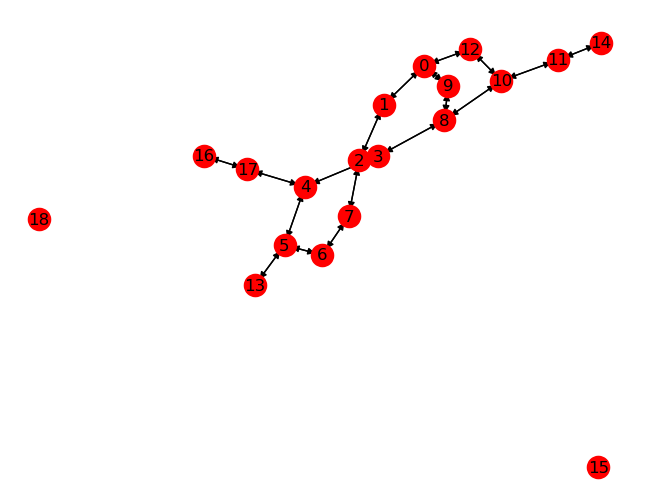

Distance between original graphs:  16.0
Distance to the first graph:  10.0
Distance to the second graph:  6.0
**********
Distance between original graphs, level = 3:  60.0
Distance to the first graph, level = 3:  38.0
Distance to the second graph, level = 3:  28.0
**********
Distance between original graphs, level = 4:  182.0
Distance to the first graph, level = 4:  116.0
Distance to the second graph, level = 4:  90.0
all nodes:  [[15, 18], [13, 14, 16], [1, 6, 7, 9, 11, 12, 17], [0, 2, 3, 4, 5, 8, 10]]
[2, 3, 1] [2, 3, 7, 7]
[2, 3, 1] [2, 3, 7, 7]
weights:  [4, 9, 7]
[2, 2, 1] [2, 2, 7, 7]
weights:  [4, 4, 7]
actions:  1 1
Nodes:  16 13
Path sum:  4


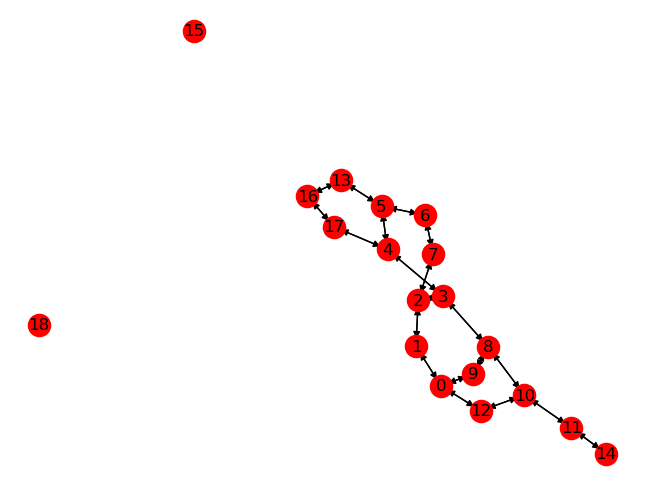

Distance between original graphs:  16.0
Distance to the first graph:  12.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  60.0
Distance to the first graph, level = 3:  46.0
Distance to the second graph, level = 3:  22.0
**********
Distance between original graphs, level = 4:  182.0
Distance to the first graph, level = 4:  142.0
Distance to the second graph, level = 4:  68.0
all nodes:  [[15, 18], [14], [1, 6, 7, 9, 11, 12, 13, 16, 17], [0, 2, 3, 4, 5, 8, 10]]
[2, 1, 1] [2, 1, 9, 7]
[2, 1, 1] [2, 1, 9, 7]
weights:  [4, 1, 9]
[2, 0, 1] [2, 0, 9, 7]
weights:  [4, 0, 9]
actions:  1 0
Nodes:  14 18
Path sum:  2


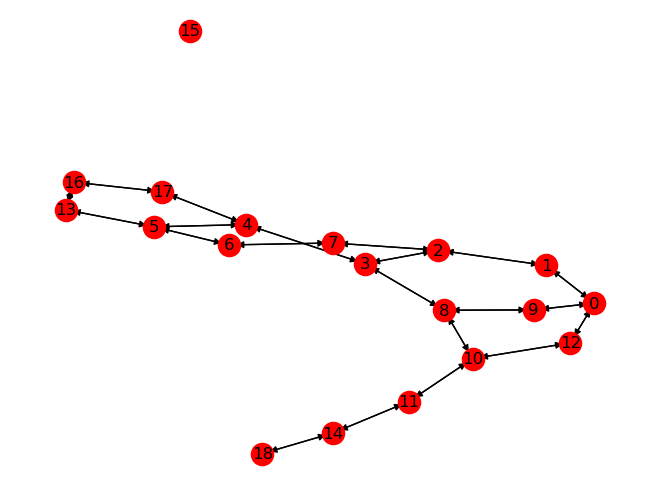

Distance between original graphs:  16.0
Distance to the first graph:  14.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  60.0
Distance to the first graph, level = 3:  52.0
Distance to the second graph, level = 3:  18.0
**********
Distance between original graphs, level = 4:  182.0
Distance to the first graph, level = 4:  156.0
Distance to the second graph, level = 4:  60.0
all nodes:  [[15], [18], [1, 6, 7, 9, 11, 12, 13, 14, 16, 17], [0, 2, 3, 4, 5, 8, 10]]
[1, 0, 1] [1, 1, 10, 7]
[1, 0, 1] [1, 1, 10, 7]
weights:  [1, 0, 10]
[1, 0, 0] [1, 1, 9, 7]
weights:  [1, 0, 0]
actions:  2 0
Nodes:  13 15
Path sum:  0


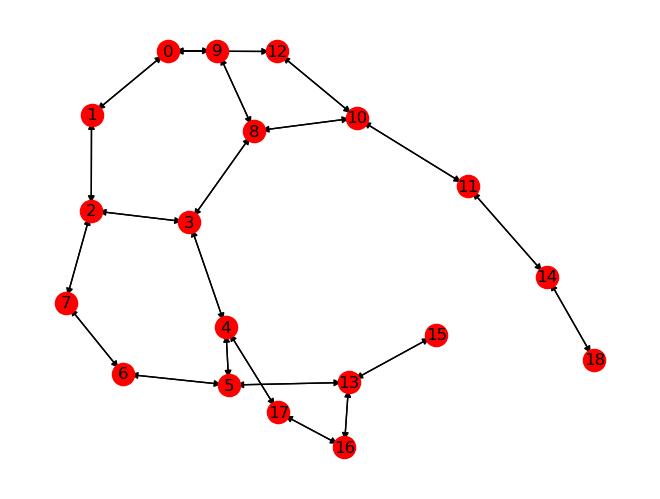

Distance between original graphs:  16.0
Distance to the first graph:  16.0
Distance to the second graph:  0.0
**********
Distance between original graphs, level = 3:  60.0
Distance to the first graph, level = 3:  60.0
Distance to the second graph, level = 3:  12.0
**********
Distance between original graphs, level = 4:  182.0
Distance to the first graph, level = 4:  180.0
Distance to the second graph, level = 4:  46.0


In [773]:
path_sum = 1
while path_sum > 0:
    g1, path, path_sum = run_step(g1, path)
    run_check(g1, d1_filled, d2)

## Following the path, example 4

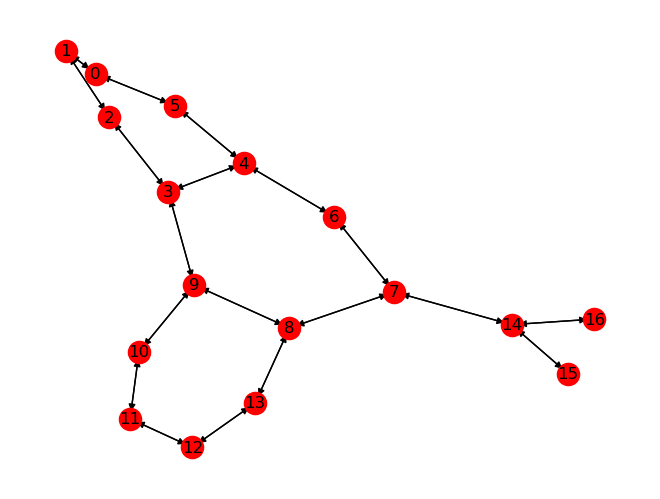

In [774]:
draw_graph(dataset[10])

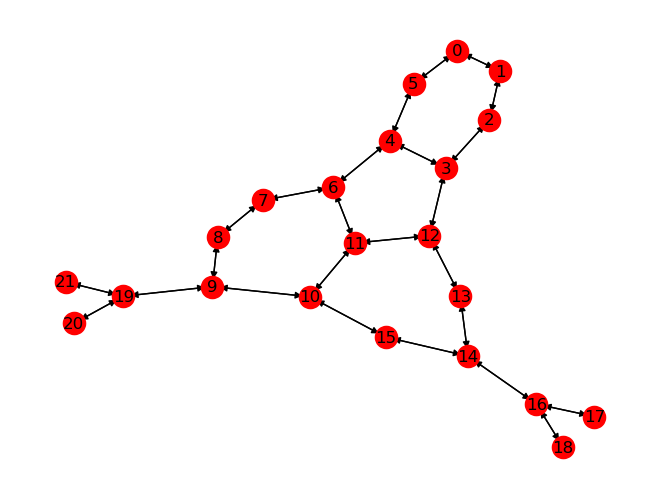

In [775]:
draw_graph(dataset[12])

In [781]:
# set datasets

d1 = dataset[10]
d2 = dataset[12]

# calculate histograms
a1, a2, max_max = calc_distrib(d1, d2)
# aff empty nodes if needed
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
    coragraph = to_networkx(d1)
    while diff > 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff - 1
    d1_filled = from_networkx(coragraph)
    d1_filled.x = torch.ones(len(list(coragraph.nodes)), 1)
    print('Change 1')
elif diff < 0: 
    a2[0] = abs(diff)
    coragraph = to_networkx(d2)
    while diff < 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff + 1
    d2_filled = from_networkx(coragraph)
    d2_filled.x = torch.ones(len(list(coragraph.nodes)), 1)
    print('Change 2')
cost_matrix = get_cost_matrix(max_max)

# dist_1, dist_2, M, wass = TMD(d1, d2, 1, L=l)
path, d = ot.emd(a1, a2, cost_matrix, log=True) 

Change 1


C:\Users\ekima\AppData\Local\Temp\ipykernel_26288\2171103183.py:31: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  path, d = ot.emd(a1, a2, cost_matrix, log=True)


In [782]:
g1 = to_networkx(d1_filled)
g1 = g1.to_undirected()
path_orig = path
# path = update_path(path_orig)

In [783]:
path_orig

array([[0, 4, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 8, 1],
       [0, 0, 0, 6]])

In [784]:

path = update_path(path_orig)
path

3
0 1
3
1 2
3
2 3
0 3
2
1 2
2
2 3
1 3


array([[0, 5, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 8, 4],
       [0, 0, 0, 6]])

all nodes:  [[17, 18, 19, 20, 21], [15, 16], [0, 1, 2, 5, 6, 10, 11, 12, 13], [3, 4, 7, 8, 9, 14]]
[5, 3, 4] [5, 2, 9, 6]
[5, 3, 4] [5, 2, 9, 6]
weights:  [25, 6, 36]
[5, 3, 3] [5, 2, 8, 6]
weights:  [25, 6, 24]
actions:  2 2
Nodes:  1 2
Path sum:  12


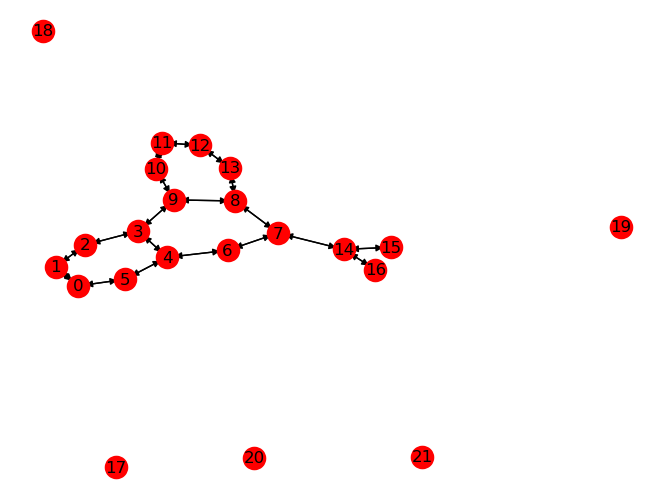

Distance between original graphs:  12.0
Distance to the first graph:  0.0
Distance to the second graph:  12.0
**********
Distance between original graphs, level = 3:  46.0
Distance to the first graph, level = 3:  0.0
Distance to the second graph, level = 3:  46.0
**********
Distance between original graphs, level = 4:  138.0
Distance to the first graph, level = 4:  0.0
Distance to the second graph, level = 4:  138.0
all nodes:  [[17, 18, 19, 20, 21], [15, 16], [0, 1, 2, 5, 6, 10, 11, 12, 13], [3, 4, 7, 8, 9, 14]]
[5, 3, 4] [5, 2, 9, 6]
[5, 3, 4] [5, 2, 9, 6]
weights:  [25, 6, 36]
[4, 3, 4] [4, 2, 9, 6]
weights:  [16, 6, 36]
actions:  0 2
Nodes:  17 10
Path sum:  10


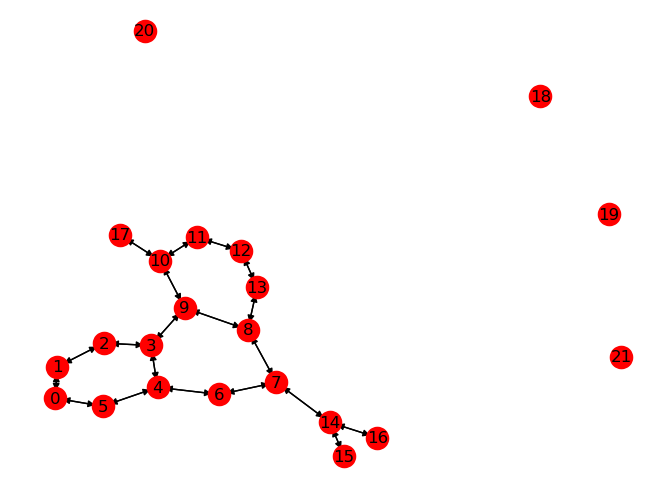

Distance between original graphs:  12.0
Distance to the first graph:  2.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  46.0
Distance to the first graph, level = 3:  8.0
Distance to the second graph, level = 3:  38.0
**********
Distance between original graphs, level = 4:  138.0
Distance to the first graph, level = 4:  24.0
Distance to the second graph, level = 4:  116.0
all nodes:  [[18, 19, 20, 21], [15, 16, 17], [0, 1, 2, 5, 6, 11, 12, 13], [3, 4, 7, 8, 9, 10, 14]]
[4, 3, 3] [4, 3, 8, 7]
[4, 3, 3] [4, 3, 8, 7]
weights:  [16, 9, 24]
[4, 3, 2] [4, 3, 7, 7]
weights:  [16, 9, 14]
actions:  2 1
Nodes:  0 17
Path sum:  8


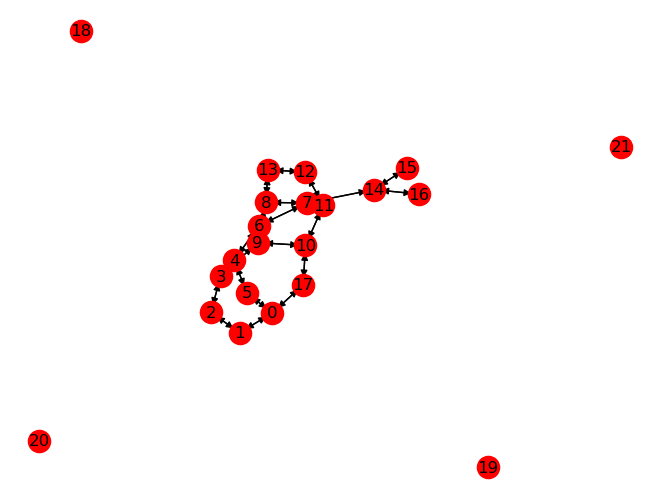

Distance between original graphs:  12.0
Distance to the first graph:  4.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  46.0
Distance to the first graph, level = 3:  18.0
Distance to the second graph, level = 3:  28.0
**********
Distance between original graphs, level = 4:  138.0
Distance to the first graph, level = 4:  60.0
Distance to the second graph, level = 4:  86.0
all nodes:  [[18, 19, 20, 21], [15, 16], [1, 2, 5, 6, 11, 12, 13, 17], [0, 3, 4, 7, 8, 9, 10, 14]]
[4, 2, 2] [4, 2, 8, 8]
[4, 2, 2] [4, 2, 8, 8]
weights:  [16, 4, 16]
[4, 2, 1] [4, 2, 7, 8]
weights:  [16, 4, 7]
actions:  2 0
Nodes:  1 21
Path sum:  6


Distance between original graphs:  12.0
Distance to the first graph:  6.0
Distance to the second graph:  6.0
**********
Distance between original graphs, level = 3:  46.0
Distance to the first graph, level = 3:  26.0
Distance to the second graph, level = 3:  24.0
**********
Distance between original graphs, level = 4:  138.0
Distance to the first graph, level = 4:  84.0
Distance to the second graph, level = 4:  72.0
all nodes:  [[18, 19, 20], [15, 16, 21], [2, 5, 6, 11, 12, 13, 17], [0, 1, 3, 4, 7, 8, 9, 10, 14]]
[3, 2, 1] [3, 3, 7, 9]
[3, 2, 1] [3, 3, 7, 9]
weights:  [9, 6, 7]
[3, 1, 1] [3, 2, 7, 9]
weights:  [9, 2, 7]
actions:  1 0
Nodes:  21 18
Path sum:  4


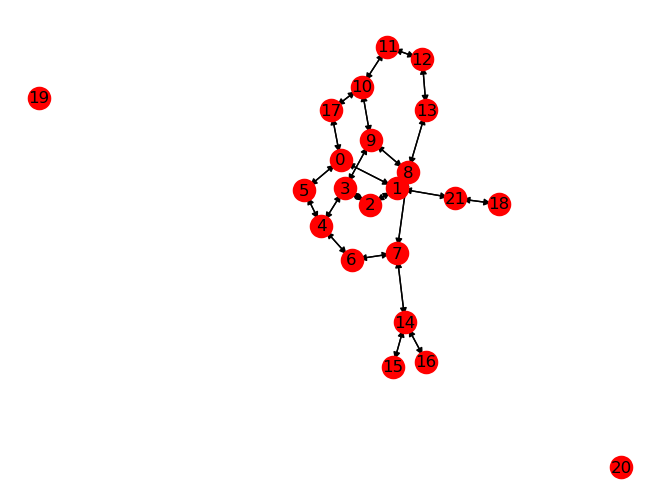

Distance between original graphs:  12.0
Distance to the first graph:  8.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  46.0
Distance to the first graph, level = 3:  32.0
Distance to the second graph, level = 3:  18.0
**********
Distance between original graphs, level = 4:  138.0
Distance to the first graph, level = 4:  100.0
Distance to the second graph, level = 4:  60.0
all nodes:  [[19, 20], [15, 16, 18], [2, 5, 6, 11, 12, 13, 17, 21], [0, 1, 3, 4, 7, 8, 9, 10, 14]]
[2, 1, 1] [2, 3, 8, 9]
[2, 1, 1] [2, 3, 8, 9]
weights:  [4, 3, 8]
[1, 1, 1] [1, 3, 8, 9]
weights:  [1, 3, 8]
actions:  0 2
Nodes:  19 11
Path sum:  2


Distance between original graphs:  12.0
Distance to the first graph:  10.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  46.0
Distance to the first graph, level = 3:  40.0
Distance to the second graph, level = 3:  14.0
**********
Distance between original graphs, level = 4:  138.0
Distance to the first graph, level = 4:  124.0
Distance to the second graph, level = 4:  52.0
all nodes:  [[20], [15, 16, 18, 19], [2, 5, 6, 12, 13, 17, 21], [0, 1, 3, 4, 7, 8, 9, 10, 11, 14]]
[1, 1, 0] [1, 4, 7, 10]
[1, 1, 0] [1, 4, 7, 10]
weights:  [1, 4, 0]
[1, 0, 0] [1, 3, 7, 10]
weights:  [1, 0, 0]
actions:  1 0
Nodes:  18 20
Path sum:  0


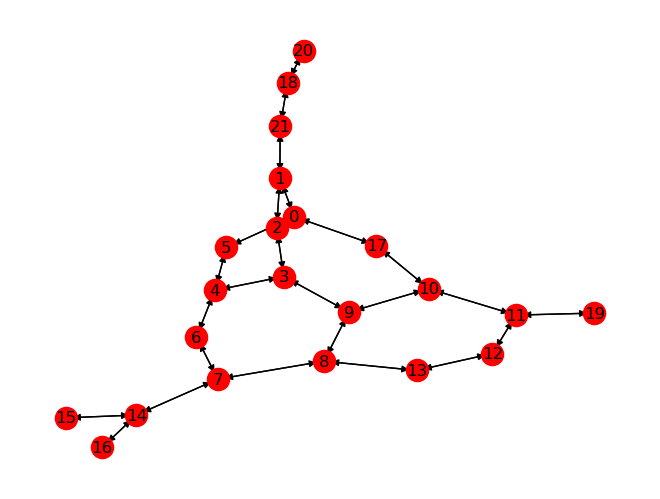

Distance between original graphs:  12.0
Distance to the first graph:  12.0
Distance to the second graph:  0.0
**********
Distance between original graphs, level = 3:  46.0
Distance to the first graph, level = 3:  46.0
Distance to the second graph, level = 3:  8.0
**********
Distance between original graphs, level = 4:  138.0
Distance to the first graph, level = 4:  138.0
Distance to the second graph, level = 4:  38.0


In [785]:
path_sum = 1
while path_sum > 0:
    g1, path, path_sum = run_step(g1, path)
    run_check(g1, d1_filled, d2)

## Barycenter for two distributions 

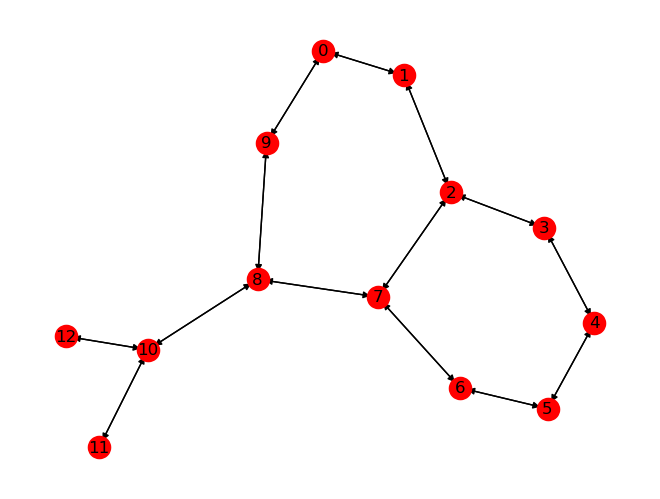

In [794]:
draw_graph(dataset[1])
# d2 = dataset[3]

In [793]:
draw_graph(dataset[3])
# d2 = dataset[3]

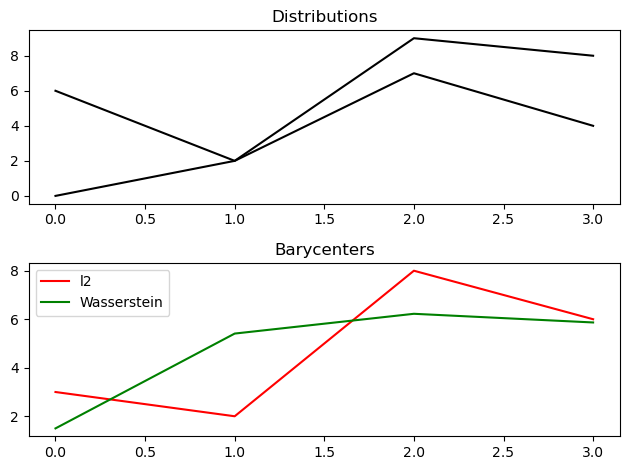

Initial distributions:  [6, 2, 7, 4] [0, 2, 9, 8]
Average:  [3. 2. 8. 6.]
Wasserstein:  [1.50000713 5.40905544 6.22426826 5.86666917]


In [237]:
d1 = dataset[1]
d2 = dataset[3]
# L = 2
a1, a2, max_max = calc_distrib(d1, d2)
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
elif diff < 0: 
    a2[0] = abs(diff)
    

# dist_1, dist_2, M, real_wass = TMD(d1, d2, 1, L=L)
bary_l2, bary_wass = calc_barycenter(a1, a2, max_max, alpha=0.5, reg=1e-3)
print("Initial distributions: ", a1, a2)
print("Average: ", bary_l2)
print("Wasserstein: ", bary_wass)

## Barycenter, example 1

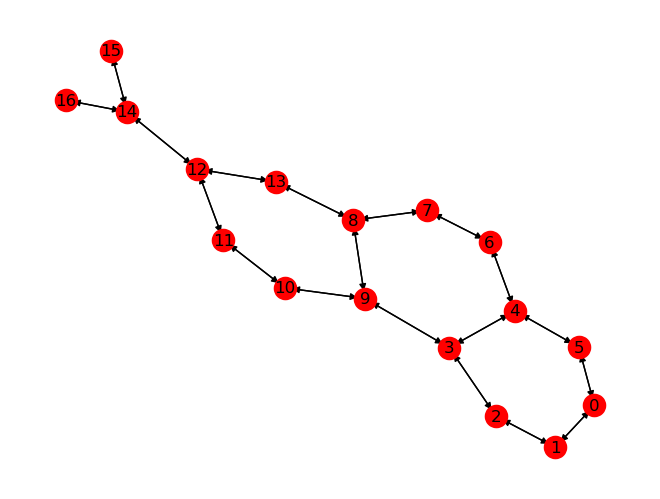

In [225]:
draw_graph(dataset[0])

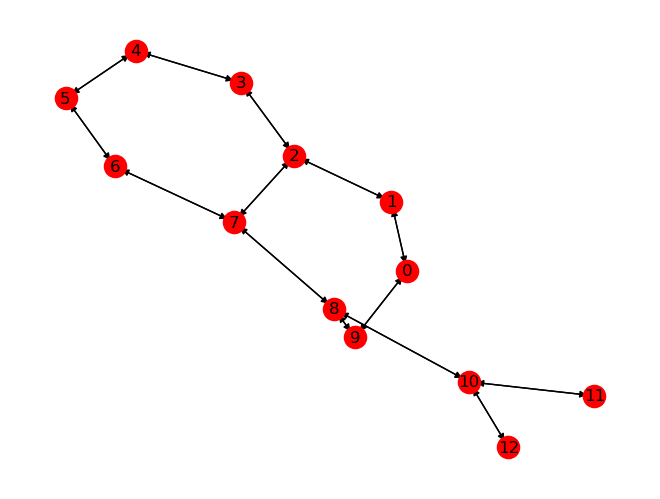

In [227]:
draw_graph(dataset[1])

In [796]:
# set datasets
d1 = dataset[0]
d2 = dataset[1]

# calculate histograms
a1, a2, max_max = calc_distrib(d1, d2)
# aff empty nodes if needed
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
    coragraph = to_networkx(d1)
    while diff > 0:
        coragraph.add_node(max(list(coragraph.nodes)))
        diff = diff - 1
    d1 = from_networkx(coragraph)
    d1.x = torch.ones(len(list(coragraph.nodes)), 1)
elif diff < 0: 
    a2[0] = abs(diff)
    coragraph = to_networkx(d2)
    while diff < 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff + 1
    d2 = from_networkx(coragraph)
    d2.x = torch.ones(len(list(coragraph.nodes)), 1)

Alpha:  0.0
[0.35890196 1.84864616 8.7515484  6.04090348]
Original histogramm 1:  [0, 2, 9, 6]
Wassernstein histogramm:  [0, 2, 9, 6]
Original histogramm 2:  [4, 2, 7, 4]
Layer =  2
Dist dataset 0 - dataset 1:  10.0
Dist dataset 0 - intermediate:  0.0
Dist intermediate - dataset 1:  10.0
Dist intermediate, sums:  10.0
Layer =  3
Dist dataset 0 - dataset 1:  36.0
Dist dataset 0 - intermediate:  16.0
Dist intermediate - dataset 1:  44.0
Dist intermediate, sums:  60.0
Layer =  4
Dist dataset 0 - dataset 1:  102.0
Dist dataset 0 - intermediate:  62.0
Dist intermediate - dataset 1:  130.0
Dist intermediate, sums:  192.0


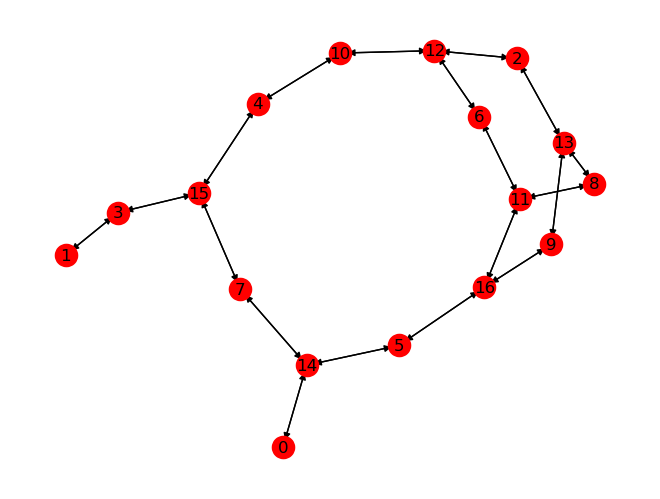

Alpha:  0.1
[0.47506783 2.24576479 8.34756712 5.93160026]
Original histogramm 1:  [0, 2, 9, 6]
Wassernstein histogramm:  [1, 2, 8, 6]
Original histogramm 2:  [4, 2, 7, 4]
Layer =  2
Dist dataset 0 - dataset 1:  10.0
Dist dataset 0 - intermediate:  2.0
Dist intermediate - dataset 1:  8.0
Dist intermediate, sums:  10.0
Layer =  3
Dist dataset 0 - dataset 1:  36.0
Dist dataset 0 - intermediate:  14.0
Dist intermediate - dataset 1:  30.0
Dist intermediate, sums:  44.0
Layer =  4
Dist dataset 0 - dataset 1:  102.0
Dist dataset 0 - intermediate:  42.0
Dist intermediate - dataset 1:  92.0
Dist intermediate, sums:  134.0


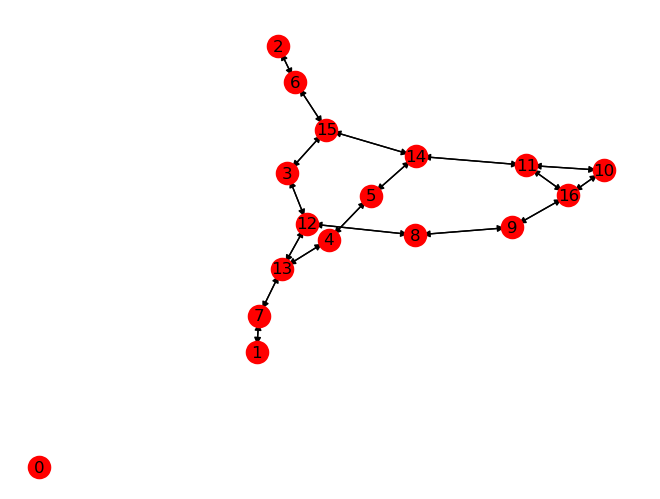

Alpha:  0.2
[0.64757322 3.0842235  7.47006944 5.79813385]
[0.66742796 3.140863   7.40817437 5.78353467]
[0.68737024 3.18412347 7.35984036 5.76866593]
[0.70736996 3.2158232  7.32334408 5.75346276]
[0.72744539 3.23901319 7.29569099 5.73785043]
[0.74764152 3.2569946  7.27360776 5.72175613]
[0.76800881 3.27261131 7.25426377 5.7051161 ]
[0.78859101 3.28797111 7.23556056 5.68787732]
[0.80942191 3.30443286 7.21615638 5.66998885]
[0.83052254 3.32287715 7.19517086 5.65142944]
[0.8519085  3.3436527  7.17228191 5.63215689]
[0.87358811 3.36686926 7.14740075 5.61214188]
[0.89556526 3.39245295 7.12062422 5.59135757]
[0.9178419  3.42018499 7.09220479 5.56976832]
[0.94041341 3.44987675 7.06233387 5.54737597]
[0.9632777  3.4811943  7.03137972 5.52414827]
[0.98642972 3.51382299 6.99967734 5.50006996]
[1.0098632  3.54743916 6.96756749 5.47513016]
[1.03357087 3.5817176  6.93538828 5.44932325]
[1.05754455 3.61633654 6.90346916 5.42264975]
[1.08177525 3.65098139 6.87212623 5.39511713]
[1.10625316 3.68534782

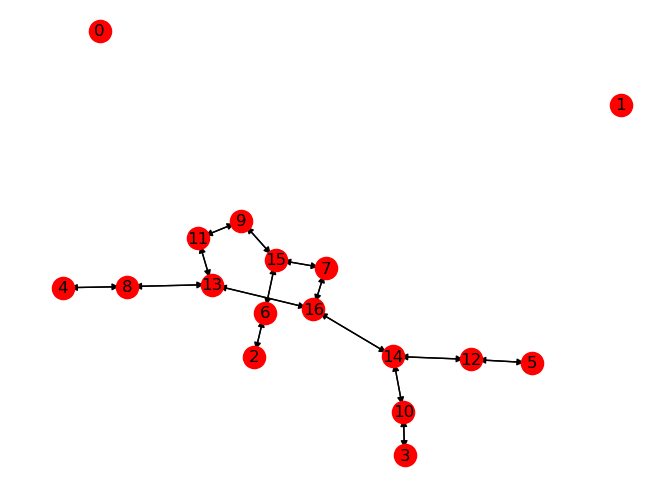

Alpha:  0.30000000000000004
[0.8519085  3.3436527  7.17228191 5.63215689]
[0.87358811 3.36686926 7.14740075 5.61214188]
[0.89556526 3.39245295 7.12062422 5.59135757]
[0.9178419  3.42018499 7.09220479 5.56976832]
[0.94041341 3.44987675 7.06233387 5.54737597]
[0.9632777  3.4811943  7.03137972 5.52414827]
[0.98642972 3.51382299 6.99967734 5.50006996]
[1.0098632  3.54743916 6.96756749 5.47513016]
[1.03357087 3.5817176  6.93538828 5.44932325]
[1.05754455 3.61633654 6.90346916 5.42264975]
[1.08177525 3.65098139 6.87212623 5.39511713]
[1.10625316 3.68534782 6.84165833 5.3667407 ]
[1.13096771 3.71914469 6.81234332 5.33754427]
[1.15590761 3.75209689 6.78443474 5.30756076]
[1.1810608  3.7839481  6.75815849 5.27683261]
[1.20641448 3.81446363 6.73370996 5.24541193]
[1.23195509 3.84343295 6.71125147 5.21336049]
[1.2576683  3.87067198 6.69091034 5.18074937]
[1.28353899 3.89602498 6.67277767 5.14765836]
[1.30955121 3.91936583 6.65690792 5.11417504]
[1.33568818 3.94059873 6.64331946 5.08039363]
[1.361

Alpha:  0.4
[1.08177525 3.65098139 6.87212623 5.39511713]
[1.10625316 3.68534782 6.84165833 5.3667407 ]
[1.13096771 3.71914469 6.81234332 5.33754427]
[1.15590761 3.75209689 6.78443474 5.30756076]
[1.1810608  3.7839481  6.75815849 5.27683261]
[1.20641448 3.81446363 6.73370996 5.24541193]
[1.23195509 3.84343295 6.71125147 5.21336049]
[1.2576683  3.87067198 6.69091034 5.18074937]
[1.28353899 3.89602498 6.67277767 5.14765836]
[1.30955121 3.91936583 6.65690792 5.11417504]
[1.33568818 3.94059873 6.64331946 5.08039363]
[1.36193222 3.95965821 6.63199598 5.0464136 ]
[1.38826474 3.97650836 6.62288884 5.01233805]
[1.41466619 3.99114158 6.61592021 4.97827202]
[1.44111599 4.00357655 6.6109868  4.94432066]
[1.46759253 4.01385586 6.60796416 4.91058745]
[1.49407304 4.02204331 6.60671117 4.87717248]
[1.52053362 4.02822089 6.60707466 4.84417083]
[1.54694917 4.03248579 6.60889383 4.81167121]
[1.57329334 4.03494745 6.61200447 4.77975475]
[1.59953855 4.03572465 6.61624272 4.74849408]
[1.62565607 4.03494291

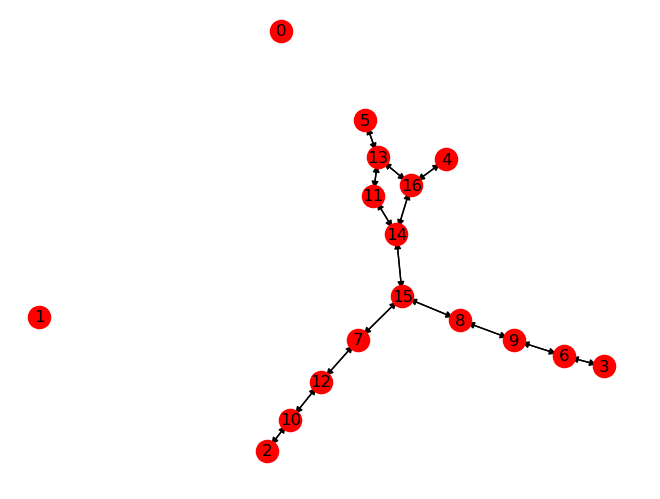

Alpha:  0.5
[1.33568818 3.94059873 6.64331946 5.08039363]
[1.36193222 3.95965821 6.63199598 5.0464136 ]
[1.38826474 3.97650836 6.62288884 5.01233805]
[1.41466619 3.99114158 6.61592021 4.97827202]
[1.44111599 4.00357655 6.6109868  4.94432066]
[1.46759253 4.01385586 6.60796416 4.91058745]
[1.49407304 4.02204331 6.60671117 4.87717248]
[1.52053362 4.02822089 6.60707466 4.84417083]
[1.54694917 4.03248579 6.60889383 4.81167121]
[1.57329334 4.03494745 6.61200447 4.77975475]
[1.59953855 4.03572465 6.61624272 4.74849408]
[1.62565607 4.03494291 6.6214483  4.71795273]
[1.65161608 4.03273198 6.62746722 4.68818471]
[1.67738796 4.02922367 6.63415393 4.65923444]
[1.70294065 4.0245497  6.6413728  4.63113685]
Original histogramm 1:  [0, 2, 9, 6]
Wassernstein histogramm:  [2, 4, 7, 4]
Original histogramm 2:  [4, 2, 7, 4]
Layer =  2
Dist dataset 0 - dataset 1:  10.0
Dist dataset 0 - intermediate:  8.0
Dist intermediate - dataset 1:  2.0
Dist intermediate, sums:  10.0
Layer =  3
Dist dataset 0 - dataset 1

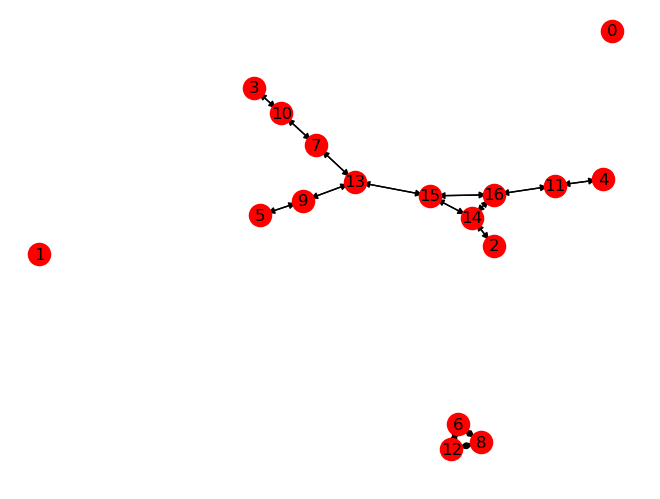

Alpha:  0.6000000000000001
[1.59953855 4.03572465 6.61624272 4.74849408]
[1.62565607 4.03494291 6.6214483  4.71795273]
[1.65161608 4.03273198 6.62746722 4.68818471]
[1.67738796 4.02922367 6.63415393 4.65923444]
[1.70294065 4.0245497  6.6413728  4.63113685]
Original histogramm 1:  [0, 2, 9, 6]
Wassernstein histogramm:  [2, 4, 7, 4]
Original histogramm 2:  [4, 2, 7, 4]
Layer =  2
Dist dataset 0 - dataset 1:  10.0
Dist dataset 0 - intermediate:  8.0
Dist intermediate - dataset 1:  2.0
Dist intermediate, sums:  10.0
Layer =  3
Dist dataset 0 - dataset 1:  36.0
Dist dataset 0 - intermediate:  32.0
Dist intermediate - dataset 1:  12.0
Dist intermediate, sums:  44.0
Layer =  4
Dist dataset 0 - dataset 1:  102.0
Dist dataset 0 - intermediate:  104.0
Dist intermediate - dataset 1:  40.0
Dist intermediate, sums:  144.0


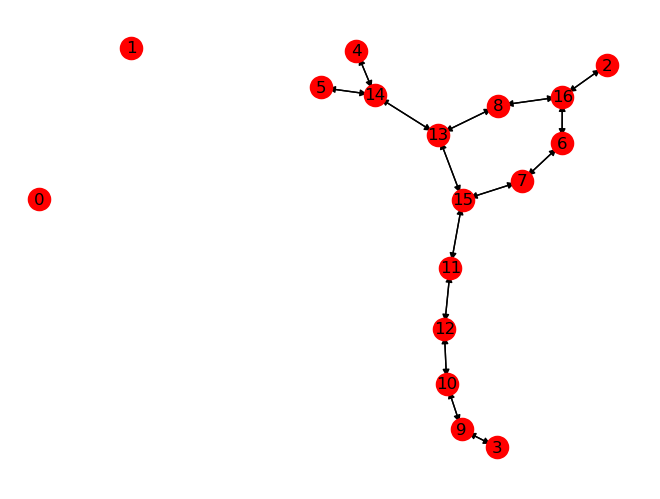

Alpha:  0.7000000000000001
[1.85013311 3.97884011 6.68969385 4.48133293]
Original histogramm 1:  [0, 2, 9, 6]
Wassernstein histogramm:  [2, 4, 7, 4]
Original histogramm 2:  [4, 2, 7, 4]
Layer =  2
Dist dataset 0 - dataset 1:  10.0
Dist dataset 0 - intermediate:  8.0
Dist intermediate - dataset 1:  2.0
Dist intermediate, sums:  10.0
Layer =  3
Dist dataset 0 - dataset 1:  36.0
Dist dataset 0 - intermediate:  32.0
Dist intermediate - dataset 1:  16.0
Dist intermediate, sums:  48.0
Layer =  4
Dist dataset 0 - dataset 1:  102.0
Dist dataset 0 - intermediate:  104.0
Dist intermediate - dataset 1:  46.0
Dist intermediate, sums:  150.0


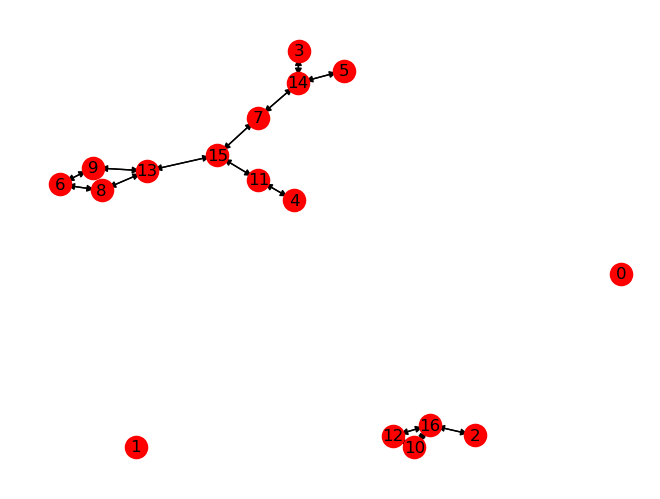

Alpha:  0.8
[2.10408836 3.83752693 6.76013795 4.29824676]
Original histogramm 1:  [0, 2, 9, 6]
Wassernstein histogramm:  [2, 4, 7, 4]
Original histogramm 2:  [4, 2, 7, 4]
Layer =  2
Dist dataset 0 - dataset 1:  10.0
Dist dataset 0 - intermediate:  8.0
Dist intermediate - dataset 1:  2.0
Dist intermediate, sums:  10.0
Layer =  3
Dist dataset 0 - dataset 1:  36.0
Dist dataset 0 - intermediate:  34.0
Dist intermediate - dataset 1:  10.0
Dist intermediate, sums:  44.0
Layer =  4
Dist dataset 0 - dataset 1:  102.0
Dist dataset 0 - intermediate:  106.0
Dist intermediate - dataset 1:  36.0
Dist intermediate, sums:  142.0


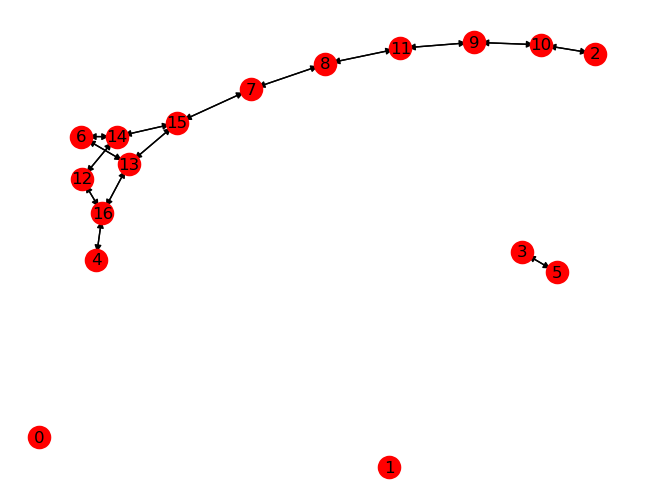

Alpha:  0.9
[2.66451429 3.35870486 6.80147855 4.17530229]
[2.7330253  3.29734835 6.80435169 4.16527466]
[2.80096287 3.23640825 6.80705639 4.15557249]
[2.8677739  3.17644464 6.80960423 4.14617723]
[2.93299342 3.11792948 6.81200574 4.13707137]
[2.99624204 3.0612492  6.81427038 4.12823839]
[3.05722121 3.00670947 6.8164066  4.11966272]
[3.11570619 2.95454017 6.8184224  4.11133124]
[3.17154216 2.90490848 6.82032313 4.10322623]
[3.22463083 2.85791642 6.8221155  4.09533725]
[3.2749267  2.81361678 6.82380456 4.08765195]
[3.322428   2.77201847 6.82539481 4.08015871]
[3.36716919 2.73309397 6.8268902  4.07284664]
[3.40921392 2.69678636 6.82829424 4.06570548]
[3.44864865 2.66301561 6.8296101  4.05872564]
[3.48557698 2.6316843  6.83084067 4.05189806]
[3.5201147  2.60268245 6.83198858 4.04521427]
[3.55238557 2.5758918  6.83305632 4.03866631]
[3.58251781 2.55118926 6.83404623 4.03224669]
Original histogramm 1:  [0, 2, 9, 6]
Wassernstein histogramm:  [4, 2, 7, 4]
Original histogramm 2:  [4, 2, 7, 4]
L

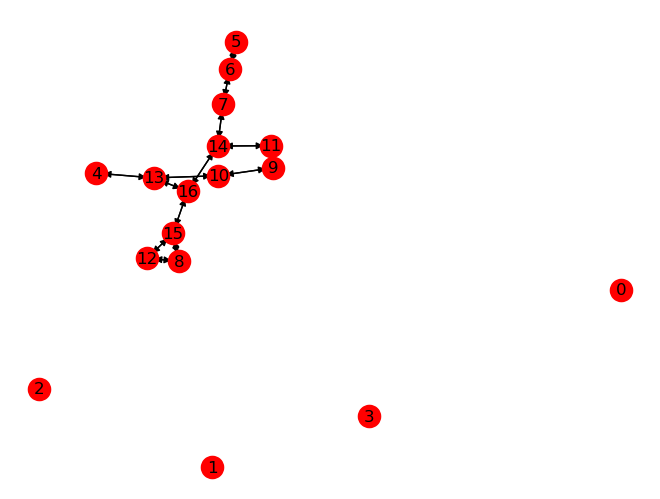

Alpha:  1.0
[3.2749267  2.81361678 6.82380456 4.08765195]
[3.322428   2.77201847 6.82539481 4.08015871]
[3.36716919 2.73309397 6.8268902  4.07284664]
[3.40921392 2.69678636 6.82829424 4.06570548]
[3.44864865 2.66301561 6.8296101  4.05872564]
[3.48557698 2.6316843  6.83084067 4.05189806]
[3.5201147  2.60268245 6.83198858 4.04521427]
[3.55238557 2.5758918  6.83305632 4.03866631]
[3.58251781 2.55118926 6.83404623 4.03224669]
Original histogramm 1:  [0, 2, 9, 6]
Wassernstein histogramm:  [4, 2, 7, 4]
Original histogramm 2:  [4, 2, 7, 4]
Layer =  2
Dist dataset 0 - dataset 1:  10.0
Dist dataset 0 - intermediate:  10.0
Dist intermediate - dataset 1:  0.0
Dist intermediate, sums:  10.0
Layer =  3
Dist dataset 0 - dataset 1:  36.0
Dist dataset 0 - intermediate:  36.0
Dist intermediate - dataset 1:  8.0
Dist intermediate, sums:  44.0
Layer =  4
Dist dataset 0 - dataset 1:  102.0
Dist dataset 0 - intermediate:  102.0
Dist intermediate - dataset 1:  28.0
Dist intermediate, sums:  130.0


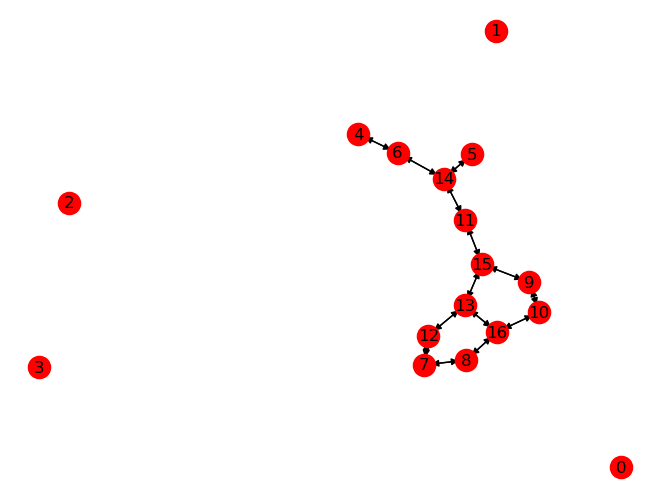

In [798]:
# calculate histograms
a1, a2, max_max = calc_distrib(d1, d2)
# aff empty nodes if needed
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
elif diff < 0: 
    a2[0] = abs(diff)

    
# set parameters
n = max_max
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]
# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

# reg = 1e-3
reg = 0.03

# set alpha list
n_alpha = 11
alpha_list = np.linspace(0, 1, n_alpha)

for i in range(n_alpha):
    # i = 5
    alpha = alpha_list[i]
    print("=" * 100)
    print("Alpha: ", alpha)
    correct_seq = False
    while correct_seq == False:
        weights = np.array([1 - alpha, alpha])
        wass_hist_double = ot.bregman.barycenter(A, M, reg, weights)
        print(wass_hist_double)
        wass_hist = [int(round(wass_hist_double[i], 0)) for i in range(len(wass_hist_double))]
        # print(wass_hist_double, wass_hist)

        # wass_hist_double = [round(B_wass[i][j], 4) for i in range(max_max)]
        while (sum(wass_hist) != sum(a1)):
            if(sum(wass_hist) > sum(a1) ): 
                diff = [wass_hist_double[i] - wass_hist[i] for i in range(len(wass_hist))]
                index = diff.index(min(diff))
                wass_hist[index] = math.floor(wass_hist_double[index])
            if(sum(wass_hist) < sum(a1) ): 
                diff = [wass_hist_double[i] - wass_hist[i] for i in range(len(wass_hist))]
                index = diff.index(max(diff))
                wass_hist[index] = math.ceil(wass_hist_double[index])

        degree_sum = sum([wass_hist[i] * i for i in range(len(wass_hist))])
        if degree_sum % 2 == 1:
            correct_seq = False
            alpha = alpha+0.01
            # print(wass_hist, degree_sum)
            # print("Bad sequence")
        else: 
            correct_seq = True
            # print(wass_hist, degree_sum )
            # print("Good sequence")
    print("Original histogramm 1: ", a1)
    print("Wassernstein histogramm: ", wass_hist)
    print("Original histogramm 2: ", a2)
#     cost_matrix = get_cost_matrix(n=max_max)
#     path, d_12 = ot.emd(a1, a2, cost_matrix, log=True) 
#     path, d_1wass = ot.emd(a1, wass_hist, cost_matrix, log=True) 
#     path, d_2wass = ot.emd(a2, wass_hist, cost_matrix, log=True) 

#     print("Cost between original sequences: ", round(d_12['cost'],3 ))
#     print("Cost between original sequence 1 and waaserstein: ", round(d_1wass['cost'],3 ))
#     print("Cost between original sequence 2 and waaserstein: ", round(d_2wass['cost'],3 ))


    res = []
    for i in range(len(wass_hist)):
        counts = wass_hist[i]
        # print(counts)
        for n in range(counts):
            res.append(i)
    # print(res)

    draw = res
    correct_grapg = False
    while(not correct_grapg):
        z = list(draw)
        G = nx.configuration_model(z)
        G = nx.Graph(G)
        G.remove_edges_from(nx.selfloop_edges(G))

        actual_degrees = [d for v, d in G.degree()]
        correct_grapg = actual_degrees == z
    # plot_graph(G)
    new_G = from_networkx(G)
    new_G.x = torch.ones(new_G.num_nodes, 1)

    levels = [2,3,4]
    for l in levels: 
        
        wass_orig = TMD_original(d1, d2, 1, L=l)
        wass_0 = TMD_original(d1, new_G, 1, L=l)
        wass_1 = TMD_original(new_G, d2, 1, L=l)
        wass_01_sum = wass_0 + wass_1
        print("Layer = ", l)
        print("Dist dataset 0 - dataset 1: ", wass_orig)
        print("Dist dataset 0 - intermediate: ", wass_0)
        print("Dist intermediate - dataset 1: ", wass_1)
        print("Dist intermediate, sums: ", wass_01_sum)
        
    draw_graph(new_G)

## Barycenter, example 2

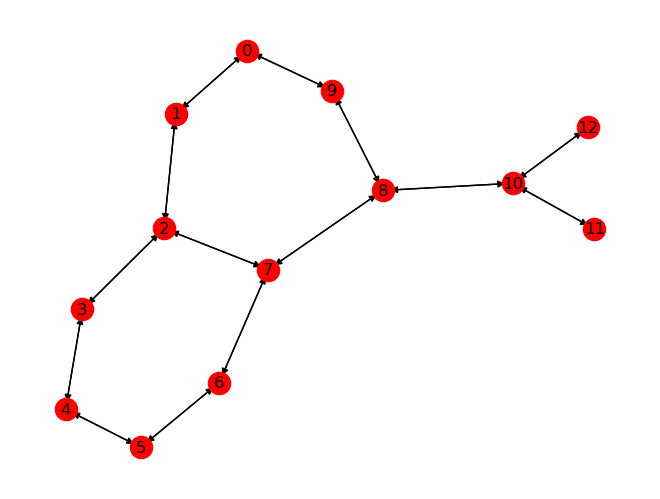

In [126]:
draw_graph(dataset[1])

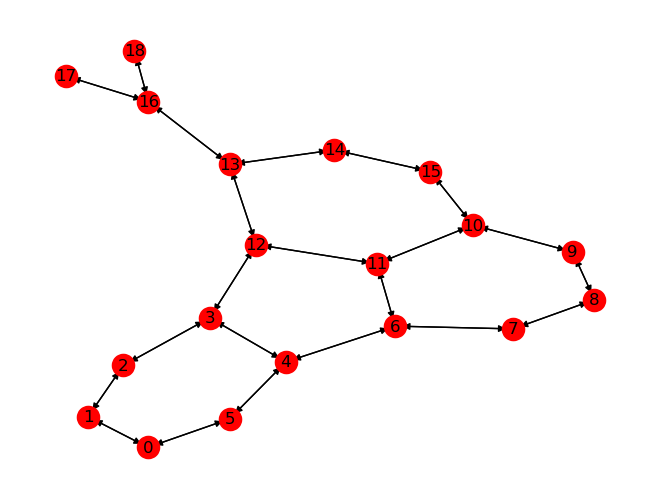

In [128]:
draw_graph(dataset[3])

In [219]:
# set datasets
d1 = dataset[1]
d2 = dataset[3]

# calculate histograms
a1, a2, max_max = calc_distrib(d1, d2)
# aff empty nodes if needed
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
    coragraph = to_networkx(d1)
    while diff > 0:
        coragraph.add_node(max(list(coragraph.nodes)))
        diff = diff - 1
    d1 = from_networkx(coragraph)
    d1.x = torch.ones(len(list(coragraph.nodes)), 1)
elif diff < 0: 
    a2[0] = abs(diff)
    coragraph = to_networkx(d2)
    while diff < 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff + 1
    d2 = from_networkx(coragraph)
    d2.x = torch.ones(len(list(coragraph.nodes)), 1)

Alpha:  0.0
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [6, 2, 7, 4]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  6.0
Dist intermediate - dataset 1:  16.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  12.0
Dist intermediate - dataset 1:  60.0
Dist intermediate, sums:  72.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  28.0
Dist intermediate - dataset 1:  180.0
Dist intermediate, sums:  208.0


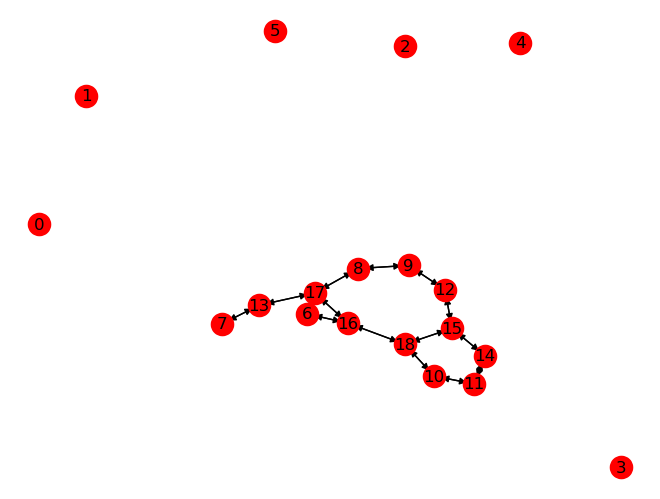

Alpha:  0.1
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [6, 2, 7, 4]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  6.0
Dist intermediate - dataset 1:  16.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  10.0
Dist intermediate - dataset 1:  60.0
Dist intermediate, sums:  70.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  24.0
Dist intermediate - dataset 1:  180.0
Dist intermediate, sums:  204.0


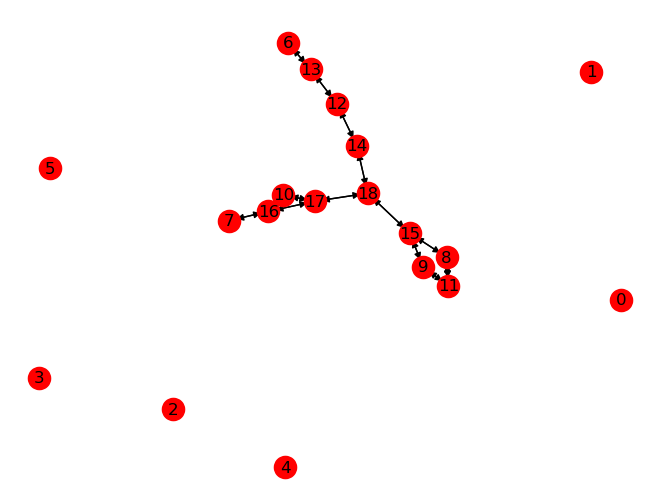

Alpha:  0.2
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [2, 6, 7, 4]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  10.0
Dist intermediate - dataset 1:  12.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  28.0
Dist intermediate - dataset 1:  52.0
Dist intermediate, sums:  80.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  72.0
Dist intermediate - dataset 1:  172.0
Dist intermediate, sums:  244.0


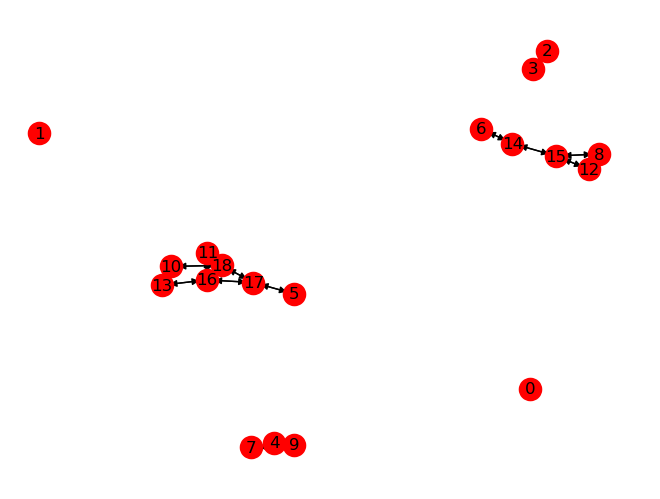

Alpha:  0.30000000000000004
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [2, 6, 7, 4]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  10.0
Dist intermediate - dataset 1:  12.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  26.0
Dist intermediate - dataset 1:  52.0
Dist intermediate, sums:  78.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  68.0
Dist intermediate - dataset 1:  178.0
Dist intermediate, sums:  246.0


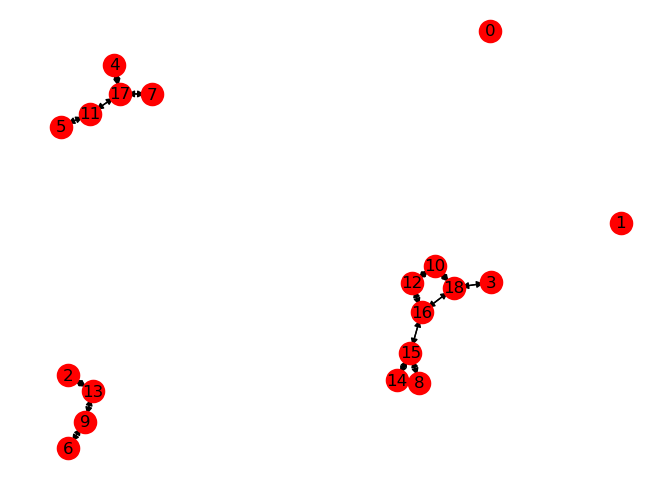

Alpha:  0.4
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [2, 6, 7, 4]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  10.0
Dist intermediate - dataset 1:  12.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  26.0
Dist intermediate - dataset 1:  52.0
Dist intermediate, sums:  78.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  76.0
Dist intermediate - dataset 1:  180.0
Dist intermediate, sums:  256.0


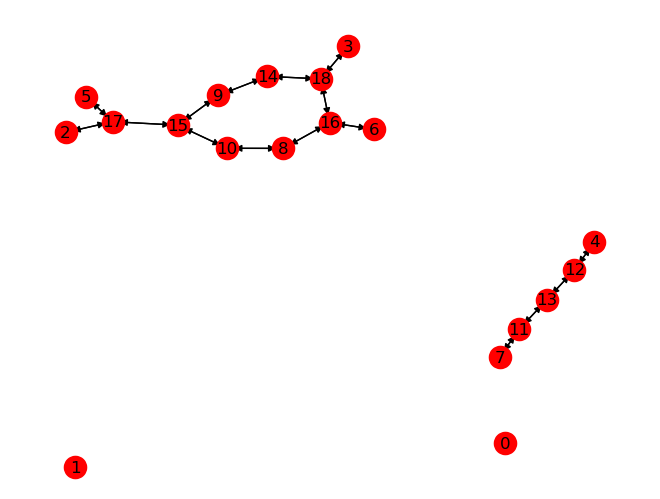

Alpha:  0.5
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [0, 6, 5, 8]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  18.0
Dist intermediate - dataset 1:  4.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  52.0
Dist intermediate - dataset 1:  22.0
Dist intermediate, sums:  74.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  148.0
Dist intermediate - dataset 1:  74.0
Dist intermediate, sums:  222.0


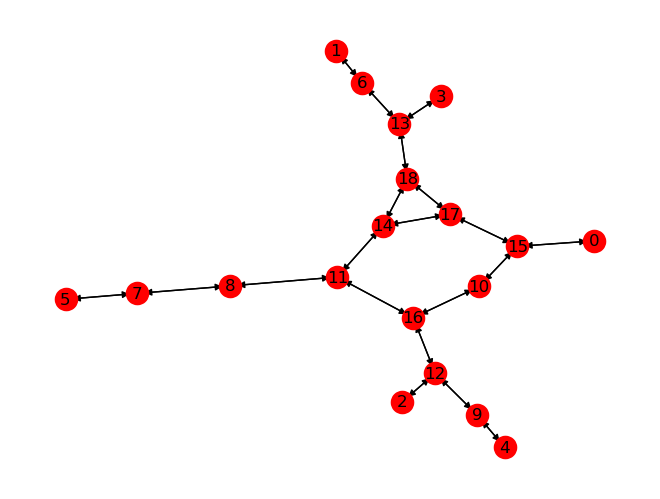

Alpha:  0.6000000000000001
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [0, 6, 5, 8]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  18.0
Dist intermediate - dataset 1:  4.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  50.0
Dist intermediate - dataset 1:  24.0
Dist intermediate, sums:  74.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  140.0
Dist intermediate - dataset 1:  84.0
Dist intermediate, sums:  224.0


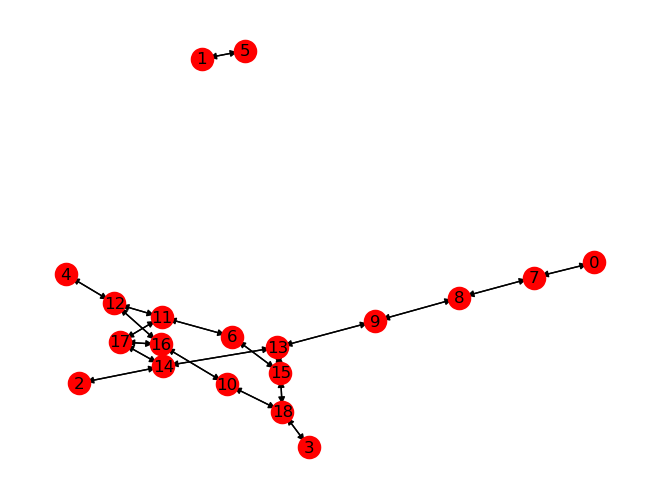

Alpha:  0.7000000000000001
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [0, 6, 5, 8]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  18.0
Dist intermediate - dataset 1:  4.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  50.0
Dist intermediate - dataset 1:  22.0
Dist intermediate, sums:  72.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  138.0
Dist intermediate - dataset 1:  76.0
Dist intermediate, sums:  214.0


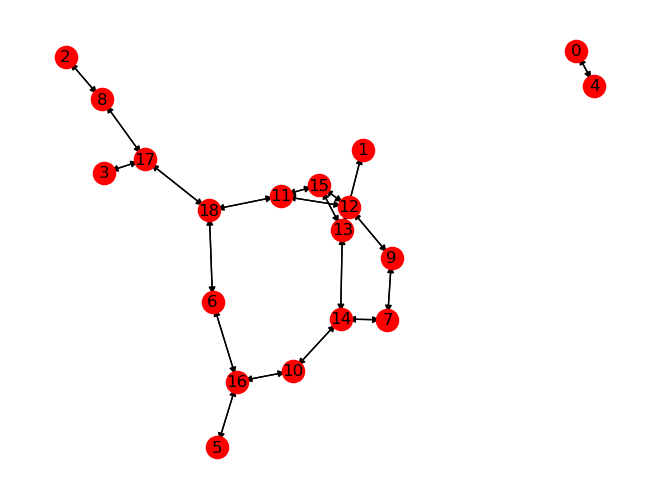

Alpha:  0.8
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [0, 2, 9, 8]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  22.0
Dist intermediate - dataset 1:  0.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  66.0
Dist intermediate - dataset 1:  10.0
Dist intermediate, sums:  76.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  188.0
Dist intermediate - dataset 1:  52.0
Dist intermediate, sums:  240.0


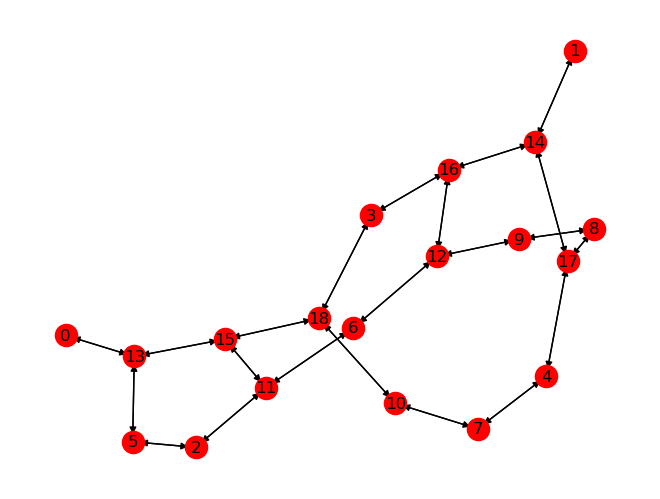

Alpha:  0.9
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [0, 2, 9, 8]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  22.0
Dist intermediate - dataset 1:  0.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  68.0
Dist intermediate - dataset 1:  22.0
Dist intermediate, sums:  90.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  190.0
Dist intermediate - dataset 1:  82.0
Dist intermediate, sums:  272.0


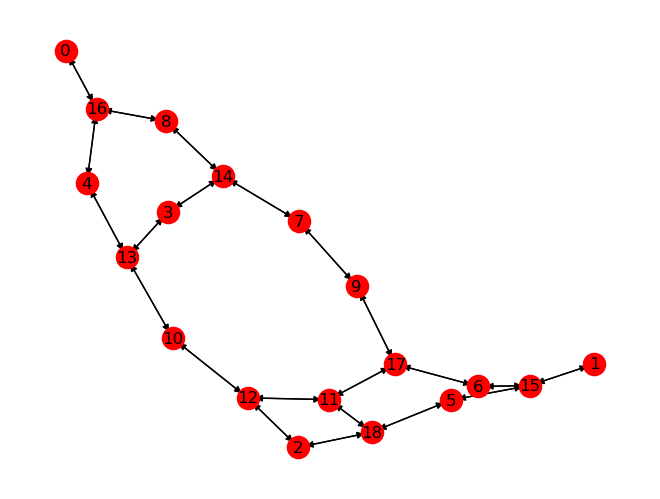

Alpha:  1.0
Original histogramm 1:  [6, 2, 7, 4]
Wassernstein histogramm:  [0, 2, 9, 8]
Original histogramm 2:  [0, 2, 9, 8]
Layer =  2
Dist dataset 0 - dataset 1:  22.0
Dist dataset 0 - intermediate:  22.0
Dist intermediate - dataset 1:  0.0
Dist intermediate, sums:  22.0
Layer =  3
Dist dataset 0 - dataset 1:  66.0
Dist dataset 0 - intermediate:  66.0
Dist intermediate - dataset 1:  12.0
Dist intermediate, sums:  78.0
Layer =  4
Dist dataset 0 - dataset 1:  188.0
Dist dataset 0 - intermediate:  186.0
Dist intermediate - dataset 1:  50.0
Dist intermediate, sums:  236.0


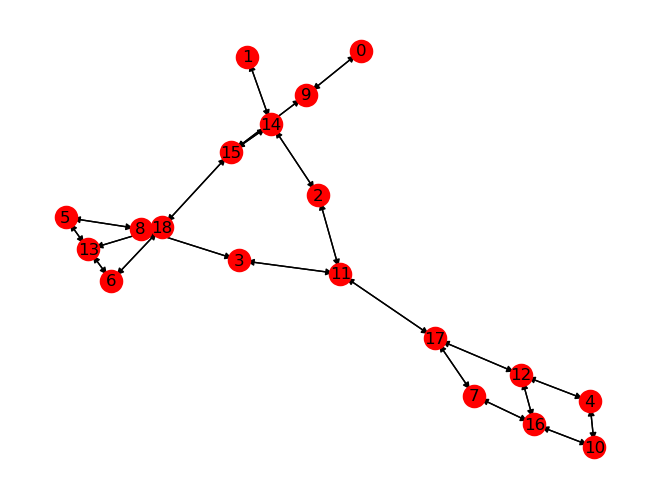

In [221]:
# calculate histograms
a1, a2, max_max = calc_distrib(d1, d2)
# aff empty nodes if needed
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
elif diff < 0: 
    a2[0] = abs(diff)

    
# set parameters
n = max_max
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]
# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

reg = 1e-3


# set alpha list
n_alpha = 11
alpha_list = np.linspace(0, 1, n_alpha)

for i in range(n_alpha):
    # i = 5
    alpha = alpha_list[i]
    print("=" * 100)
    print("Alpha: ", alpha)
    correct_seq = False
    while correct_seq == False:
        weights = np.array([1 - alpha, alpha])
        wass_hist_double = ot.bregman.barycenter(A, M, reg, weights)
        wass_hist = [int(round(wass_hist_double[i], 0)) for i in range(len(wass_hist_double))]
        # print(wass_hist_double, wass_hist)

        # wass_hist_double = [round(B_wass[i][j], 4) for i in range(max_max)]
        while (sum(wass_hist) != sum(a1)):
            if(sum(wass_hist) > sum(a1) ): 
                diff = [wass_hist_double[i] - wass_hist[i] for i in range(len(wass_hist))]
                index = diff.index(min(diff))
                wass_hist[index] = math.floor(wass_hist_double[index])
            if(sum(wass_hist) < sum(a1) ): 
                diff = [wass_hist_double[i] - wass_hist[i] for i in range(len(wass_hist))]
                index = diff.index(max(diff))
                wass_hist[index] = math.ceil(wass_hist_double[index])

        degree_sum = sum([wass_hist[i] * i for i in range(len(wass_hist))])
        if degree_sum % 2 == 1:
            correct_seq = False
            alpha = alpha+0.01
            # print(wass_hist, degree_sum)
            # print("Bad sequence")
        else: 
            correct_seq = True
            # print(wass_hist, degree_sum )
            # print("Good sequence")
    print("Original histogramm 1: ", a1)
    print("Wassernstein histogramm: ", wass_hist)
    print("Original histogramm 2: ", a2)
#     cost_matrix = get_cost_matrix(n=max_max)
#     path, d_12 = ot.emd(a1, a2, cost_matrix, log=True) 
#     path, d_1wass = ot.emd(a1, wass_hist, cost_matrix, log=True) 
#     path, d_2wass = ot.emd(a2, wass_hist, cost_matrix, log=True) 

#     print("Cost between original sequences: ", round(d_12['cost'],3 ))
#     print("Cost between original sequence 1 and waaserstein: ", round(d_1wass['cost'],3 ))
#     print("Cost between original sequence 2 and waaserstein: ", round(d_2wass['cost'],3 ))


    res = []
    for i in range(len(wass_hist)):
        counts = wass_hist[i]
        # print(counts)
        for n in range(counts):
            res.append(i)
    # print(res)

    draw = res
    correct_grapg = False
    while(not correct_grapg):
        z = list(draw)
        G = nx.configuration_model(z)
        G = nx.Graph(G)
        G.remove_edges_from(nx.selfloop_edges(G))

        actual_degrees = [d for v, d in G.degree()]
        correct_grapg = actual_degrees == z
    # plot_graph(G)
    new_G = from_networkx(G)
    new_G.x = torch.ones(new_G.num_nodes, 1)

    levels = [2,3,4]
    for l in levels: 
        
        wass_orig = TMD_original(d1, d2, 1, L=l)
        wass_0 = TMD_original(d1, new_G, 1, L=l)
        wass_1 = TMD_original(new_G, d2, 1, L=l)
        wass_01_sum = wass_0 + wass_1
        print("Layer = ", l)
        print("Dist dataset 0 - dataset 1: ", wass_orig)
        print("Dist dataset 0 - intermediate: ", wass_0)
        print("Dist intermediate - dataset 1: ", wass_1)
        print("Dist intermediate, sums: ", wass_01_sum)
        
    draw_graph(new_G)

## Another example

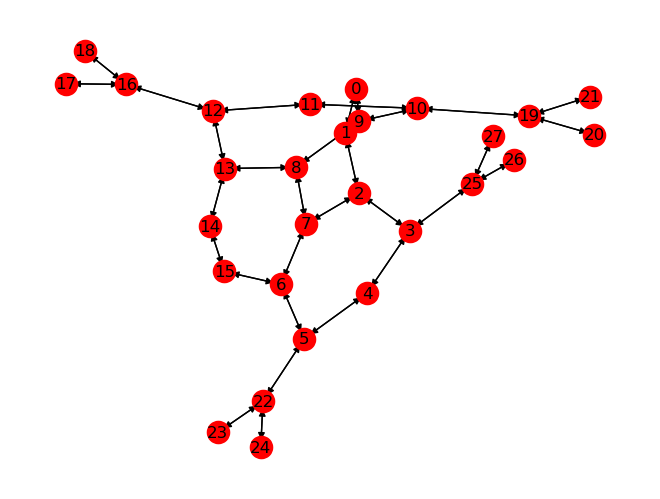

In [130]:
draw_graph(dataset[5])

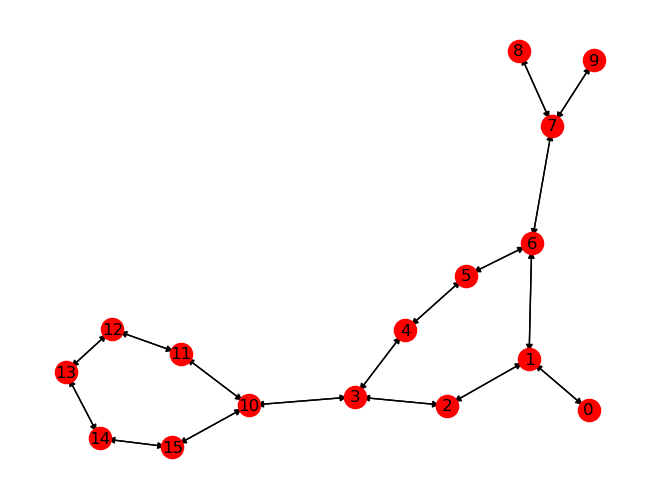

In [ ]:
draw_graph(dataset[6])

In [799]:
# set datasets
d1 = dataset[5]
d2 = dataset[6]

# calculate histograms
a1, a2, max_max = calc_distrib(d1, d2)
# aff empty nodes if needed
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
    coragraph = to_networkx(d1)
    while diff > 0:
        coragraph.add_node(max(list(coragraph.nodes)))
        diff = diff - 1
    d1 = from_networkx(coragraph)
    d1.x = torch.ones(len(list(coragraph.nodes)), 1)
elif diff < 0: 
    a2[0] = abs(diff)
    coragraph = to_networkx(d2)
    while diff < 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff + 1
    d2 = from_networkx(coragraph)
    d2.x = torch.ones(len(list(coragraph.nodes)), 1)

Alpha:  0.0
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [0, 8, 6, 14]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  0.0
Cost between original sequence 2 and waaserstein:  28.0


C:\Users\ekima\AppData\Local\Temp\ipykernel_26288\2191090713.py:63: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  path, d_12 = ot.emd(a1, a2, cost_matrix, log=True)
C:\Users\ekima\AppData\Local\Temp\ipykernel_26288\2191090713.py:64: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  path, d_1wass = ot.emd(a1, wass_hist, cost_matrix, log=True)
C:\Users\ekima\AppData\Local\Temp\ipykernel_26288\2191090713.py:65: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure 

Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  0.0
Dist intermediate - dataset 1:  28.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  16.0
Dist intermediate - dataset 1:  106.0
Dist intermediate, sums:  122.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  80.0
Dist intermediate - dataset 1:  322.0
Dist intermediate, sums:  402.0


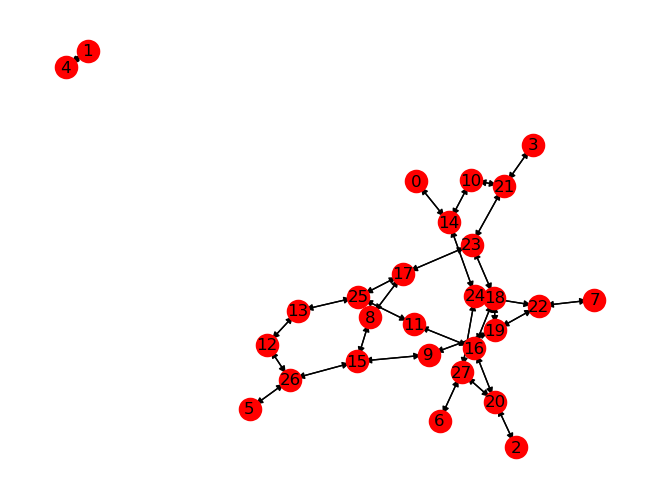

Alpha:  0.1
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [0, 8, 6, 14]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  0.0
Cost between original sequence 2 and waaserstein:  28.0
Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  0.0
Dist intermediate - dataset 1:  28.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  12.0
Dist intermediate - dataset 1:  106.0
Dist intermediate, sums:  118.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  66.0
Dist intermediate - dataset 1:  314.0
Dist intermediate, sums:  380.0


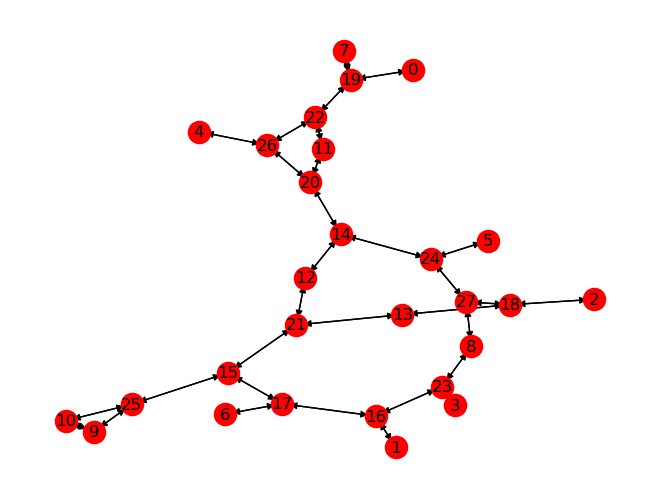

Alpha:  0.2
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [0, 8, 6, 14]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  0.0
Cost between original sequence 2 and waaserstein:  28.0
Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  0.0
Dist intermediate - dataset 1:  28.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  16.0
Dist intermediate - dataset 1:  106.0
Dist intermediate, sums:  122.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  88.0
Dist intermediate - dataset 1:  316.0
Dist intermediate, sums:  404.0


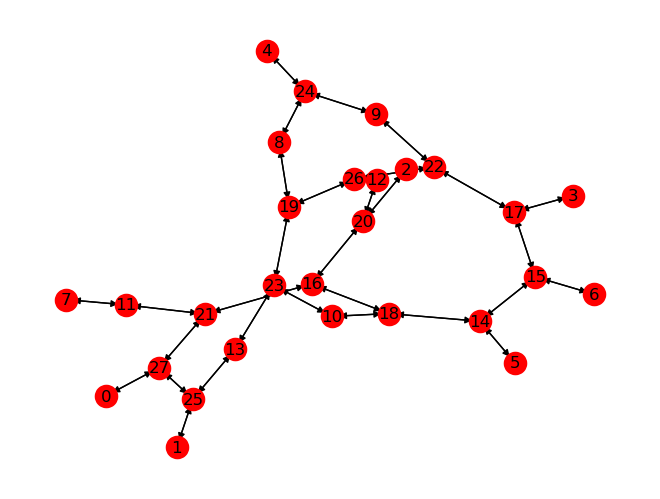

Alpha:  0.30000000000000004
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [1, 11, 3, 13]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  6.0
Cost between original sequence 2 and waaserstein:  22.0
Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  6.0
Dist intermediate - dataset 1:  22.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  30.0
Dist intermediate - dataset 1:  82.0
Dist intermediate, sums:  112.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  118.0
Dist intermediate - dataset 1:  242.0
Dist intermediate, sums:  360.0


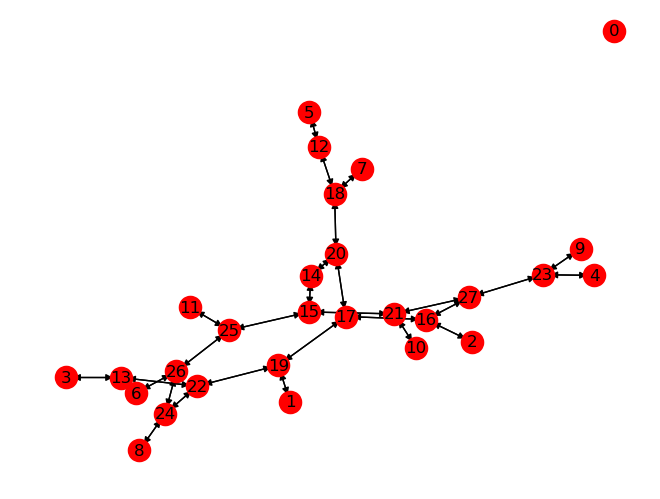

Alpha:  0.4
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [1, 11, 3, 13]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  6.0
Cost between original sequence 2 and waaserstein:  22.0
Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  6.0
Dist intermediate - dataset 1:  22.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  40.0
Dist intermediate - dataset 1:  82.0
Dist intermediate, sums:  122.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  138.0
Dist intermediate - dataset 1:  262.0
Dist intermediate, sums:  400.0


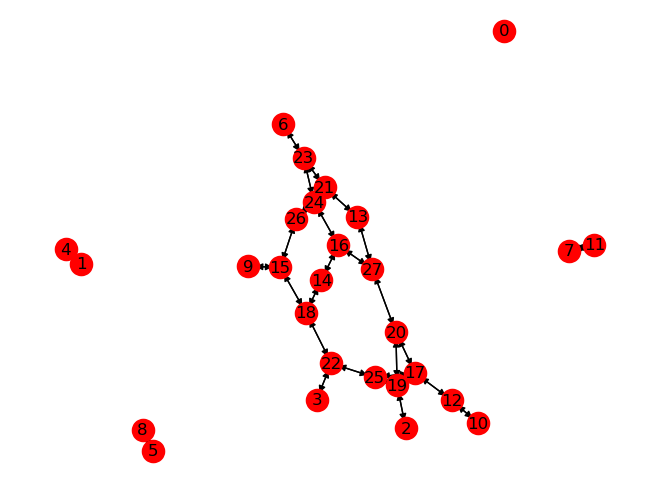

Alpha:  0.5
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [5, 8, 7, 8]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  16.0
Cost between original sequence 2 and waaserstein:  12.0
Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  16.0
Dist intermediate - dataset 1:  12.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  66.0
Dist intermediate - dataset 1:  40.0
Dist intermediate, sums:  106.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  206.0
Dist intermediate - dataset 1:  116.0
Dist intermediate, sums:  322.0


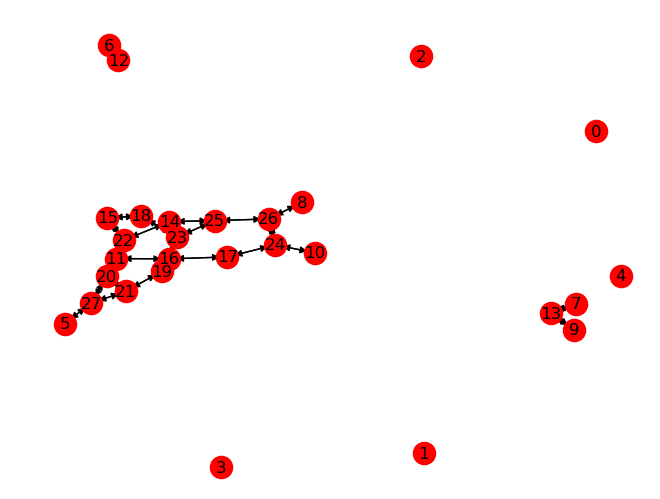

Alpha:  0.6000000000000001
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [8, 7, 8, 5]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  24.0
Cost between original sequence 2 and waaserstein:  4.0
Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  24.0
Dist intermediate - dataset 1:  4.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  98.0
Dist intermediate - dataset 1:  16.0
Dist intermediate, sums:  114.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  308.0
Dist intermediate - dataset 1:  54.0
Dist intermediate, sums:  362.0


Alpha:  0.7000000000000001
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [8, 7, 8, 5]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  24.0
Cost between original sequence 2 and waaserstein:  4.0
Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  24.0
Dist intermediate - dataset 1:  4.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  98.0
Dist intermediate - dataset 1:  24.0
Dist intermediate, sums:  122.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  314.0
Dist intermediate - dataset 1:  74.0
Dist intermediate, sums:  388.0


Alpha:  0.8
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [8, 7, 8, 5]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  24.0
Cost between original sequence 2 and waaserstein:  4.0
Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  24.0
Dist intermediate - dataset 1:  4.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  98.0
Dist intermediate - dataset 1:  22.0
Dist intermediate, sums:  120.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  310.0
Dist intermediate - dataset 1:  66.0
Dist intermediate, sums:  376.0


Alpha:  0.9
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [12, 3, 8, 5]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  28.0
Cost between original sequence 2 and waaserstein:  0.0
Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  28.0
Dist intermediate - dataset 1:  0.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  106.0
Dist intermediate - dataset 1:  10.0
Dist intermediate, sums:  116.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  314.0
Dist intermediate - dataset 1:  44.0
Dist intermediate, sums:  358.0


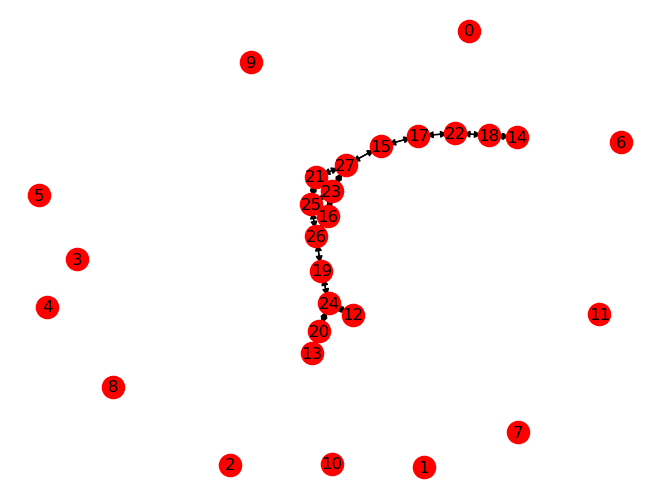

Alpha:  1.0
Original histogramm 1:  [0, 8, 6, 14]
Wassernstein histogramm:  [12, 3, 8, 5]
Original histogramm 2:  [12, 3, 8, 5]
Cost between original sequences:  28.0
Cost between original sequence 1 and waaserstein:  28.0
Cost between original sequence 2 and waaserstein:  0.0
Layer =  2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  28.0
Dist intermediate - dataset 1:  0.0
Dist intermediate, sums:  28.0
Layer =  3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  106.0
Dist intermediate - dataset 1:  4.0
Dist intermediate, sums:  110.0
Layer =  4
Dist dataset 0 - dataset 1:  316.0
Dist dataset 0 - intermediate:  314.0
Dist intermediate - dataset 1:  28.0
Dist intermediate, sums:  342.0


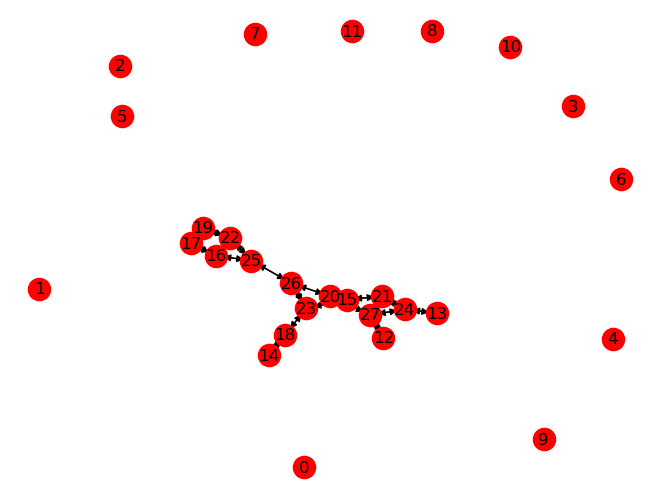

In [788]:
# calculate histograms
a1, a2, max_max = calc_distrib(d1, d2)
# aff empty nodes if needed
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
elif diff < 0: 
    a2[0] = abs(diff)

    
# set parameters
n = max_max
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]
# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

reg = 1e-3


# set alpha list
n_alpha = 11
alpha_list = np.linspace(0, 1, n_alpha)

for i in range(n_alpha):
    # i = 5
    alpha = alpha_list[i]
    print("=" * 100)
    print("Alpha: ", alpha)
    correct_seq = False
    while correct_seq == False:
        weights = np.array([1 - alpha, alpha])
        wass_hist_double = ot.bregman.barycenter(A, M, reg, weights)
        wass_hist = [int(round(wass_hist_double[i], 0)) for i in range(len(wass_hist_double))]
        # print(wass_hist_double, wass_hist)

        # wass_hist_double = [round(B_wass[i][j], 4) for i in range(max_max)]
        while (sum(wass_hist) != sum(a1)):
            if(sum(wass_hist) > sum(a1) ): 
                diff = [wass_hist_double[i] - wass_hist[i] for i in range(len(wass_hist))]
                index = diff.index(min(diff))
                wass_hist[index] = math.floor(wass_hist_double[index])
            if(sum(wass_hist) < sum(a1) ): 
                diff = [wass_hist_double[i] - wass_hist[i] for i in range(len(wass_hist))]
                index = diff.index(max(diff))
                wass_hist[index] = math.ceil(wass_hist_double[index])

        degree_sum = sum([wass_hist[i] * i for i in range(len(wass_hist))])
        if degree_sum % 2 == 1:
            correct_seq = False
            alpha = alpha+0.01
            # print(wass_hist, degree_sum)
            # print("Bad sequence")
        else: 
            correct_seq = True
            # print(wass_hist, degree_sum )
            # print("Good sequence")
    print("Original histogramm 1: ", a1)
    print("Wassernstein histogramm: ", wass_hist)
    print("Original histogramm 2: ", a2)
    cost_matrix = get_cost_matrix(n=max_max)
    path, d_12 = ot.emd(a1, a2, cost_matrix, log=True) 
    path, d_1wass = ot.emd(a1, wass_hist, cost_matrix, log=True) 
    path, d_2wass = ot.emd(a2, wass_hist, cost_matrix, log=True) 

    print("Cost between original sequences: ", round(d_12['cost'],3 ))
    print("Cost between original sequence 1 and waaserstein: ", round(d_1wass['cost'],3 ))
    print("Cost between original sequence 2 and waaserstein: ", round(d_2wass['cost'],3 ))


    res = []
    for i in range(len(wass_hist)):
        counts = wass_hist[i]
        # print(counts)
        for n in range(counts):
            res.append(i)
    # print(res)

    draw = res
    correct_grapg = False
    while(not correct_grapg):
        z = list(draw)
        G = nx.configuration_model(z)
        G = nx.Graph(G)
        G.remove_edges_from(nx.selfloop_edges(G))

        actual_degrees = [d for v, d in G.degree()]
        correct_grapg = actual_degrees == z
    # plot_graph(G)
    new_G = from_networkx(G)
    new_G.x = torch.ones(new_G.num_nodes, 1)

    levels = [2,3,4]
    for l in levels: 
        
        wass_orig = TMD_original(d1, d2, 1, L=l)
        wass_0 = TMD_original(d1, new_G, 1, L=l)
        wass_1 = TMD_original(new_G, d2, 1, L=l)
        wass_01_sum = wass_0 + wass_1
        print("Layer = ", l)
        print("Dist dataset 0 - dataset 1: ", wass_orig)
        print("Dist dataset 0 - intermediate: ", wass_0)
        print("Dist intermediate - dataset 1: ", wass_1)
        print("Dist intermediate, sums: ", wass_01_sum)
        
    draw_graph(new_G)

## Havel Hakimi graph generation

[1.19302286e-23 8.00000000e+00 6.00000000e+00 1.40000000e+01]
A1:  [0, 8, 6, 14]
A2:  [12, 3, 8, 5]
Barycenter:  [1.19302286e-23 8.00000000e+00 6.00000000e+00 1.40000000e+01]
[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


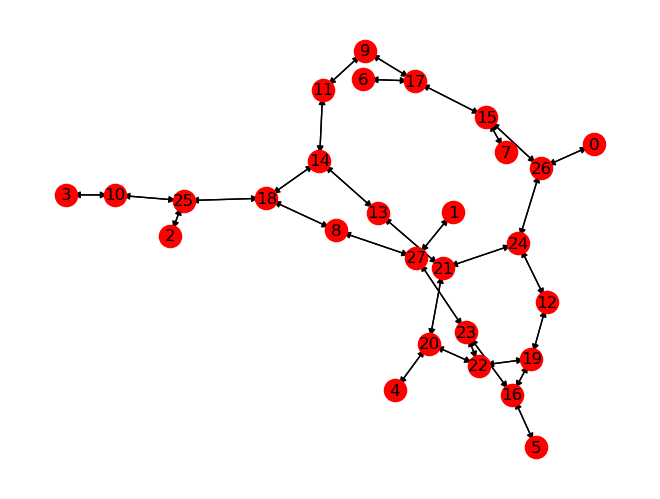

Layer = 2
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  0.0
Dist intermediate - dataset 1:  28.0
Layer = 2, G1
Dist dataset 0 - dataset 1:  28.0
Dist dataset 0 - intermediate:  0.0
Dist intermediate - dataset 1:  28.0
Layer = 3
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  12.0
Dist intermediate - dataset 1:  106.0
Layer = 3, G1
Dist dataset 0 - dataset 1:  106.0
Dist dataset 0 - intermediate:  44.0
Dist intermediate - dataset 1:  106.0


In [790]:
alpha = 0.0
weights = np.array([1 - alpha, alpha])
bary_wass = ot.bregman.barycenter(A, M, reg, weights)
    
print(bary_wass)

print("A1: ", a1)
print("A2: ", a2)
print("Barycenter: ", bary_wass)

center = [int(round(i, 0)) for i in bary_wass]

res = []
for i in range(len(center)):
    counts = center[i]
    # print(counts)
    for n in range(counts):
        res.append(i)
print(res)


draw = res
is_good = False
while(not is_good):
    z = list(draw)
    G = nx.configuration_model(z)
    G1 = nx.havel_hakimi_graph(z)
    G = nx.Graph(G)
    G1 = nx.Graph(G1)
    G.remove_edges_from(nx.selfloop_edges(G))
    actual_degrees = [d for v, d in G.degree()]
    is_good = actual_degrees == z
# plot_graph(G)
new_G = from_networkx(G)
new_G1 = from_networkx(G1)
new_G.x = torch.ones(new_G.num_nodes, 1)
draw_graph(new_G)
new_G1.x = torch.ones(new_G1.num_nodes, 1)
draw_graph(new_G1)
wass_orig = TMD_original(d1, d2, 1, L=2)
wass_0 = TMD_original(d1, new_G, 1, L=2)
wass_1 = TMD_original(new_G, d2, 1, L=2)
print("Layer = 2")
print("Dist dataset 0 - dataset 1: ", wass_orig)
print("Dist dataset 0 - intermediate: ", wass_0)
print("Dist intermediate - dataset 1: ", wass_1)



wass_orig = TMD_original(d1, d2, 1, L=2)
wass_0 = TMD_original(d1, new_G1, 1, L=2)
wass_1 = TMD_original(new_G1, d2, 1, L=2)
print("Layer = 2, G1")
print("Dist dataset 0 - dataset 1: ", wass_orig)
print("Dist dataset 0 - intermediate: ", wass_0)
print("Dist intermediate - dataset 1: ", wass_1)



wass_orig = TMD_original(d1, d2, 1, L=3)
wass_0 = TMD_original(d1, new_G, 1, L=3)
wass_1 = TMD_original(new_G, d2, 1, L=3)
print("Layer = 3")
print("Dist dataset 0 - dataset 1: ", wass_orig)
print("Dist dataset 0 - intermediate: ", wass_0)
print("Dist intermediate - dataset 1: ", wass_1)



wass_orig = TMD_original(d1, d2, 1, L=3)
wass_0 = TMD_original(d1, new_G1, 1, L=3)
wass_1 = TMD_original(new_G1, d2, 1, L=3)
print("Layer = 3, G1")
print("Dist dataset 0 - dataset 1: ", wass_orig)
print("Dist dataset 0 - intermediate: ", wass_0)
print("Dist intermediate - dataset 1: ", wass_1)

In [ ]:
# https://pythonot.github.io/gen_modules/ot.gromov.html - pot package 